# BI Exam May 2025: COVID-19 Data

#### Created by Group 7 - Kamilla, Jeanette, Juvena

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn import tree
from sklearn import model_selection
from sklearn import preprocessing as prep
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import silhouette_score
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
import statsmodels.api as sm

# Set plot styles for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Data Preparation

### 1. Load the Data

Now that we have our tools ready, the next step is to load the COVID-19 dataset into Python so we can start analyzing it.

In this case, we’re working with a single dataset:

- **OWID COVID-19 Latest Data**: a CSV file that contains country-level information on cases, deaths, vaccinations, testing, and various socioeconomic indicators.

We'll use Pandas to read the CSV file and store it as a DataFrame. To make our code cleaner and reusable, we'll define a simple function that loads the data and performs some initial checks. This way, we can easily reload or replace the dataset if needed in future steps.

In [2]:
# File paths for the covid datasets. (dataset: last updated 2024-08-04)
dataset_covid = 'Data/owid-covid-latest.csv'

# Function to load the Excel files
def load_csv_to_dataframe(file_path):
    # Reads the Excel file and skips the first row if it contains a description or title
    df = pd.read_csv(file_path)
    return df

# Load datasets
print("..Loading COVID-19 dataset")
df_covid = load_csv_to_dataframe(dataset_covid)

..Loading COVID-19 dataset


---

### 2. Explore the Data

After loading the dataset, we want to explore it to understand what kind of information it contains and how it's structured.

To do this, we can use several helpful Pandas functions such as `shape`, `types`, `info()`, `head()`, `tail()`, `sample()`, `describe()` and `isnull().sum()`. These functions will give us insights into the number of rows and columns, the data types of each column, a summary of the data, and any missing values. 

This exploration is crucial as it helps us identify potential issues or areas that need further cleaning or transformation before we proceed with our analysis. 

In [3]:
# Check the shape of the DataFrame (rows, columns)
df_covid.shape

(247, 67)

In [4]:
# Display the types of attributes (colum names) in the DataFrame
df_covid.dtypes

iso_code                                    object
continent                                   object
location                                    object
last_updated_date                           object
total_cases                                float64
                                            ...   
population                                 float64
excess_mortality_cumulative_absolute       float64
excess_mortality_cumulative                float64
excess_mortality                           float64
excess_mortality_cumulative_per_million    float64
Length: 67, dtype: object

In [5]:
# Gives an overview of the DataFrame
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    247 non-null    object 
 1   continent                                   235 non-null    object 
 2   location                                    247 non-null    object 
 3   last_updated_date                           247 non-null    object 
 4   total_cases                                 246 non-null    float64
 5   new_cases                                   242 non-null    float64
 6   new_cases_smoothed                          242 non-null    float64
 7   total_deaths                                246 non-null    float64
 8   new_deaths                                  243 non-null    float64
 9   new_deaths_smoothed                         243 non-null    float64
 10  total_cases_pe

In [6]:
# Display the first 5 rows of the DataFrame
df_covid.head()

,iso_code,continent,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2024-08-04,235214.0,0.0,0.000,7998.0,0.0,0.0,...,NaN,37.746,0.50,64.83,0.511,4.112877e+07,NaN,NaN,NaN,NaN
1,OWID_AFR,NaN,Africa,2024-08-04,13145380.0,36.0,5.143,259117.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.426737e+09,NaN,NaN,NaN,NaN
2,ALB,Europe,Albania,2024-08-04,335047.0,0.0,0.000,3605.0,0.0,0.0,...,51.2,NaN,2.89,78.57,0.795,2.842318e+06,NaN,NaN,NaN,NaN
3,DZA,Africa,Algeria,2024-08-04,272139.0,18.0,2.571,6881.0,0.0,0.0,...,30.4,83.741,1.90,76.88,0.748,4.490323e+07,NaN,NaN,NaN,NaN
4,ASM,Oceania,American Samoa,2024-08-04,8359.0,0.0,0.000,34.0,0.0,0.0,...,NaN,NaN,NaN,73.74,NaN,4.429500e+04,NaN,NaN,NaN,NaN


In [7]:
# Display the last 5 rows of the DataFrame
df_covid.tail()

,iso_code,continent,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
242,WLF,Oceania,Wallis and Futuna,2024-08-04,3760.0,0.0,0.000,9.0,0.0,0.000,...,NaN,NaN,NaN,79.94,NaN,1.159600e+04,NaN,NaN,NaN,NaN
243,OWID_WRL,NaN,World,2024-08-14,775866783.0,47169.0,6738.429,7057132.0,815.0,116.429,...,34.635,60.130,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
244,YEM,Asia,Yemen,2024-08-04,11945.0,0.0,0.000,2159.0,0.0,0.000,...,29.200,49.542,0.700,66.12,0.470,3.369661e+07,NaN,NaN,NaN,NaN
245,ZMB,Africa,Zambia,2024-08-04,349842.0,18.0,2.571,4077.0,0.0,0.000,...,24.700,13.938,2.000,63.89,0.584,2.001767e+07,NaN,NaN,NaN,NaN
246,ZWE,Africa,Zimbabwe,2024-08-04,266386.0,0.0,0.000,5740.0,0.0,0.000,...,30.700,36.791,1.700,61.49,0.571,1.632054e+07,NaN,NaN,NaN,NaN


In [8]:
# Display a random sample of 5 rows from the DataFrame
df_covid.sample(5)

,iso_code,continent,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
102,IDN,Asia,Indonesia,2024-08-04,6829399.0,46.0,6.571,162059.0,0.0,0.000,...,76.1,64.204,1.04,71.72,0.718,275501344.0,NaN,NaN,NaN,NaN
5,AND,Europe,Andorra,2024-08-04,48015.0,0.0,0.000,159.0,0.0,0.000,...,37.8,NaN,NaN,83.73,0.868,79843.0,NaN,NaN,NaN,NaN
105,IRL,Europe,Ireland,2024-08-04,1745088.0,761.0,108.714,9744.0,9.0,1.286,...,25.7,NaN,2.96,82.30,0.955,5023108.0,NaN,NaN,NaN,NaN
185,BLM,North America,Saint Barthelemy,2024-08-04,5507.0,0.0,0.000,5.0,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,10994.0,NaN,NaN,NaN,NaN
236,URY,South America,Uruguay,2024-08-04,1041346.0,15.0,2.143,7682.0,0.0,0.000,...,19.9,NaN,2.80,77.91,0.817,3422796.0,NaN,NaN,NaN,NaN


In [9]:
# Gives summary statistics for all numerical columns in the dataset
df_covid.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,2.460000e+02,242.000000,242.000000,2.460000e+02,243.000000,243.00000,246.000000,242.000000,242.000000,246.000000,...,145.000000,96.000000,173.000000,231.000000,190.000000,2.470000e+02,0.0,0.0,0.0,0.0
mean,1.336634e+07,885.607438,126.515355,1.198689e+05,14.032922,2.00472,203988.255797,22.204909,3.172136,1271.427736,...,32.909897,50.788844,3.097012,73.660866,0.722500,1.307656e+08,NaN,NaN,NaN,NaN
std,6.568130e+07,4854.786157,693.540908,5.747240e+05,92.179347,13.16853,200456.902140,82.962646,11.851812,1322.697453,...,13.621757,32.124848,2.555777,7.405725,0.149398,6.684333e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,7.700000,1.188000,0.100000,53.280000,0.394000,4.700000e+01,NaN,NaN,NaN,NaN
25%,2.750950e+04,0.000000,0.000000,1.837500e+02,0.000000,0.00000,21257.766500,0.000000,0.000000,144.808250,...,22.600000,20.482000,1.300000,69.545000,0.603000,4.294955e+05,NaN,NaN,NaN,NaN
50%,2.320985e+05,0.000000,0.000000,2.205500e+03,0.000000,0.00000,135384.895000,0.000000,0.000000,877.689000,...,33.100000,49.690500,2.500000,75.050000,0.740000,5.970430e+06,NaN,NaN,NaN,NaN
75%,1.703974e+06,5.500000,0.785500,1.938850e+04,0.000000,0.00000,340625.300000,0.232000,0.033250,2032.222000,...,41.300000,82.686750,4.200000,79.285000,0.828750,2.895671e+07,NaN,NaN,NaN,NaN
max,7.758668e+08,47169.000000,6738.429000,7.057132e+06,815.000000,116.42900,763598.600000,672.437000,96.062000,6601.110000,...,78.100000,100.000000,13.800000,86.750000,0.957000,7.975105e+09,NaN,NaN,NaN,NaN


##### **2.1 Summary of exploring the data**

After exploring the dataframe, we found that it contains a large number of columns, many of which are not useful for our analysis or modeling goals. While some columns provide valuable information (like total cases, deaths, and vaccination rates), others are either redundant, mostly empty, or irrelevant.

This highlights the need for a thorough data cleaning step to remove unnecessary columns, handle missing values, and focus only on the most relevant features for our machine learning tasks.

### 3. Clean the Data

After loading and exploring the data, we need to clean it to ensure that our analysis is accurate and meaningful. Data cleaning involves several steps, including: checking for missing values, removing duplicates, and converting data types.

We start by doing a bit of cleaning of the big dataset, to remove rows and columns that are not relevant for our futher analysis and before we seperate the data into more specific datasets.

In [10]:
# Check for missing values in the DataFrame
df_covid.isnull().sum()

iso_code                                     0
continent                                   12
location                                     0
last_updated_date                            0
total_cases                                  1
                                          ... 
population                                   0
excess_mortality_cumulative_absolute       247
excess_mortality_cumulative                247
excess_mortality                           247
excess_mortality_cumulative_per_million    247
Length: 67, dtype: int64

The output above shows that many columns contain no values at all, so we will remove them to clean up the dataset.

In [11]:
# Before cleaning the data, we want to remove irrelevant OWID aggregate rows—such as those representing high-income, low-income, and other income groupings.
rows_to_remove = ["OWID_UMC", "OWID_WRL", "OWID_LMC", "OWID_LIC", "OWID_HIC"]
df_removed_rows = df_covid[~df_covid["iso_code"].isin(rows_to_remove)]

We are removing the 'low-income countries', 'lower-middle-income countries', 'upper-middle-income countries', 'high-income countries' and 'world' categories because they are too broad and lack specific country-level detail, making it difficult to draw meaningful conclusions without relying on assumptions.

In [12]:
# Checking if the above rows were removed
print(f"{df_covid.shape}")
print(f"Removed the {df_covid.shape[0] - df_removed_rows.shape[0]} OWID rows from the dataframe.")

(247, 67)
Removed the 5 OWID rows from the dataframe.


In [13]:
# We will drop all columns with no values at all like; excess_mortality_cumulative_absolute, excess_mortality_cumulative etc.
df_covid_removed_columns = df_removed_rows.dropna(axis=1, how='all')

In [14]:
# Check whether the columns were removed
print(f"COVID dataframe shape after removing columns: {df_covid_removed_columns.shape}")
print(f"Removed {df_covid.shape[1] - df_covid_removed_columns.shape[1]} columns from the dataframe.")

COVID dataframe shape after removing columns: (242, 52)
Removed 15 columns from the dataframe.


#### 3.1 Separating the data into different datasets

Now we separate the continent-level , age-level and health-level data into their own DataFrames so that we can clean and process them independently from the country-level data. This allows us to apply different cleaning steps based on the nature of the data, since data may have different structures or missing values compared to individual countries.

##### 3.1.1 Separating the continent-level data

In [15]:
# Function to filter the DataFrame based on a list of values
def filter_dataframe(df, values, filter_type='rows', row_filter_column=None):
    if filter_type == 'rows':
        if row_filter_column is None:
            raise ValueError("Must specify 'row_filter_column' when filtering rows.")
        return df[df[row_filter_column].isin(values)]
    elif filter_type == 'columns':
        # Keep only columns present in df and in values list (avoid key error)
        columns_to_keep = [col for col in values if col in df.columns]
        return df[columns_to_keep]
    else:
        raise ValueError("filter_type must be either 'rows' or 'columns'")

In [16]:
# Before removing the iso_code column, we want to secure the OWID fields for the continents since it could be relevant data to analyze.
rows_to_secure = ["OWID_AFR", "OWID_ASI", "OWID_EUR", "OWID_EUN", "OWID_NAM", "OWID_OCE", "OWID_SAM"]
df_continents = filter_dataframe(df_covid_removed_columns, rows_to_secure, filter_type='rows', row_filter_column='iso_code')

In [17]:
# Check if the rows were secured
df_continents

,iso_code,continent,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population
1,OWID_AFR,NaN,Africa,2024-08-04,13145380.0,36.0,5.143,259117.0,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426737e+09
12,OWID_ASI,NaN,Asia,2024-08-14,301499099.0,4515.0,645.000,1637249.0,17.0,2.429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.721383e+09
70,OWID_EUR,NaN,Europe,2024-08-14,252916868.0,39047.0,5578.143,2102483.0,162.0,23.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.448078e+08
71,OWID_EUN,NaN,European Union (27),2024-08-14,185822587.0,25642.0,3663.143,1262988.0,150.0,21.429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.501468e+08
161,OWID_NAM,NaN,North America,2024-08-04,124492666.0,454.0,64.857,1671178.0,619.0,88.429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.003237e+08
166,OWID_OCE,NaN,Oceania,2024-08-11,15003352.0,1809.0,258.429,32918.0,16.0,2.286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.503886e+07
207,OWID_SAM,NaN,South America,2024-08-04,68809418.0,1308.0,186.857,1354187.0,1.0,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.368167e+08


We now have a new seperate dataframe called `df_continent` that contains the continent-level data. This DataFrame will be used for further analysis and modeling, while the original `df_covid` DataFrame will focus on country-level data.

In [18]:
# Remove the columns that are irrelavnt since they contain no values at all like; population_density, median_age etc.
df_continents_romved_columns = df_continents.dropna(axis=1, how='all')
df_continents_romved_columns

,iso_code,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,population
1,OWID_AFR,Africa,2024-08-04,13145380.0,36.0,5.143,259117.0,0.0,0.000,9088.877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426737e+09
12,OWID_ASI,Asia,2024-08-14,301499099.0,4515.0,645.000,1637249.0,17.0,2.429,63948.200,...,258.0,193.0,192.83,78.14,73.33,38.45,0.0,10.0,0.0,4.721383e+09
70,OWID_EUR,Europe,2024-08-14,252916868.0,39047.0,5578.143,2102483.0,162.0,23.143,337990.340,...,64.0,17.0,187.88,70.33,66.29,49.02,0.0,2.0,0.0,7.448078e+08
71,OWID_EUN,European Union (27),2024-08-14,185822587.0,25642.0,3663.143,1262988.0,150.0,21.429,413754.220,...,64.0,17.0,211.29,75.11,72.86,62.74,0.0,2.0,0.0,4.501468e+08
161,OWID_NAM,North America,2024-08-04,124492666.0,454.0,64.857,1671178.0,619.0,88.429,205992.190,...,442.0,442.0,192.99,76.39,65.71,42.69,1.0,0.0,0.0,6.003237e+08
166,OWID_OCE,Oceania,2024-08-11,15003352.0,1809.0,258.429,32918.0,16.0,2.286,333039.800,...,1130.0,1130.0,196.18,64.30,62.33,56.40,25.0,0.0,0.0,4.503886e+07
207,OWID_SAM,South America,2024-08-04,68809418.0,1308.0,186.857,1354187.0,1.0,0.143,159838.720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.368167e+08


The columns `new_vaccinations_smoothed_per_million`, `new_people_vaccinated_smoothed` and `new_people_vaccinated_smoothed_per_hundred` contain a lot of missing values so they are not necessary for our analysis and we will drop them from the `df_continents_cleaned` DataFrame. By removing them, we can simplify the DataFrame and focus on the most relevant features for our analysis.

In [19]:
# Check whether the columns were removed
print(f"df_continent shape after removing columns: {df_continents_romved_columns.shape}")
print(f"Removed {df_continents.shape[1] - df_continents_romved_columns.shape[1]} columns from the dataframe.")

df_continent shape after removing columns: (7, 29)
Removed 23 columns from the dataframe.


In [20]:
# Removing columns there are irrelevant 
df_continents_cleaned = df_continents_romved_columns.drop(['iso_code', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred'], axis=1)
df_continents_cleaned

,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,population
1,Africa,2024-08-04,13145380.0,36.0,5.143,259117.0,0.0,0.000,9088.877,0.025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426737e+09
12,Asia,2024-08-14,301499099.0,4515.0,645.000,1637249.0,17.0,2.429,63948.200,0.958,...,3.689439e+09,3.462095e+09,1.815177e+09,258.0,193.0,192.83,78.14,73.33,38.45,4.721383e+09
70,Europe,2024-08-14,252916868.0,39047.0,5578.143,2102483.0,162.0,23.143,337990.340,52.181,...,5.238143e+08,4.937513e+08,3.650999e+08,64.0,17.0,187.88,70.33,66.29,49.02,7.448078e+08
71,European Union (27),2024-08-14,185822587.0,25642.0,3663.143,1262988.0,150.0,21.429,413754.220,57.095,...,3.381196e+08,3.279674e+08,2.824388e+08,64.0,17.0,211.29,75.11,72.86,62.74,4.501468e+08
161,North America,2024-08-04,124492666.0,454.0,64.857,1671178.0,619.0,88.429,205992.190,0.751,...,4.585635e+08,3.944939e+08,2.562648e+08,442.0,442.0,192.99,76.39,65.71,42.69,6.003237e+08
166,Oceania,2024-08-11,15003352.0,1809.0,258.429,32918.0,16.0,2.286,333039.800,40.156,...,2.896050e+07,2.807290e+07,2.540095e+07,1130.0,1130.0,196.18,64.30,62.33,56.40,4.503886e+07
207,South America,2024-08-04,68809418.0,1308.0,186.857,1354187.0,1.0,0.143,159838.720,3.038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.368167e+08


In [21]:
# Check for duplicates in the DataFrame
df_continents_cleaned.duplicated().sum()

0

We still have some rows with missing values in the df_continents_cleaned DataFrame, so we will impute them to ensure that our analysis is accurate and meaningful. This step is important because missing values can lead to biased results or errors in our models.

Since it is a small dataframe, we can't delete the row with missing values(NaN), since we will lose a lot of data. We choose to replace the missing values, even though it can have a high risk of giving wrong information and have a big impact. 

The first four we replaced using realistic data.
But since it took too much time, we’ll use the median to fill the remaining NaN values.

In [22]:
# method for replacing cell with a value
def replace_cell(df, row_filter, column, value):
    df.loc[row_filter, column] = value

# replace NaN for total_vaccinations for Africa. 1.084.500.000 is from Africa CDC, which is offical and reliable.
replace_cell(df_continents_cleaned, df_continents_cleaned['location'] == 'Africa', 'total_vaccinations', 1084500000)

# replace NaN for total_vaccinations for South America. 970.800.000 is from WTO-IMF COVID-19 Vaccine Trade Tracker, which is offical and reliable.
replace_cell(df_continents_cleaned, df_continents_cleaned['location'] == 'South America', 'total_vaccinations', 970800000)

# replace NaN for people_vaccinated for Africa. 725.000.000 is from Africa CDC, which is offical and reliable
replace_cell(df_continents_cleaned, df_continents_cleaned['location'] == 'Africa', 'people_vaccinated', 725000000)

# replace NaN for people_vaccinated for South America. 351.310.000 is from Our World in Data which is offical and reliable used by WHO.
replace_cell(df_continents_cleaned, df_continents_cleaned['location'] == 'South America', 'people_vaccinated', 351310000)

# method for replacing cell with median 
def fill_na_with_median(df, column_name):
    median_value = df[column_name].median()
    print(f"Median of '{column_name}': {median_value:.2f}")
    df[column_name].fillna(median_value, inplace=True)


fill_na_with_median(df_continents_cleaned, 'people_fully_vaccinated')
fill_na_with_median(df_continents_cleaned, 'total_boosters')
fill_na_with_median(df_continents_cleaned, 'new_vaccinations')
fill_na_with_median(df_continents_cleaned, 'new_vaccinations_smoothed')
fill_na_with_median(df_continents_cleaned, 'total_vaccinations_per_hundred')
fill_na_with_median(df_continents_cleaned, 'people_vaccinated_per_hundred')
fill_na_with_median(df_continents_cleaned, 'people_fully_vaccinated_per_hundred')
fill_na_with_median(df_continents_cleaned, 'total_boosters_per_hundred')
df_continents_cleaned

Median of 'people_fully_vaccinated': 394493922.00
Median of 'total_boosters': 282438789.00
Median of 'new_vaccinations': 258.00
Median of 'new_vaccinations_smoothed': 193.00
Median of 'total_vaccinations_per_hundred': 192.99
Median of 'people_vaccinated_per_hundred': 75.11
Median of 'people_fully_vaccinated_per_hundred': 66.29
Median of 'total_boosters_per_hundred': 49.02


/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3133756775.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(median_value, inplace=True)


,location,last_updated_date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,population
1,Africa,2024-08-04,13145380.0,36.0,5.143,259117.0,0.0,0.000,9088.877,0.025,...,7.250000e+08,3.944939e+08,2.824388e+08,258.0,193.0,192.99,75.11,66.29,49.02,1.426737e+09
12,Asia,2024-08-14,301499099.0,4515.0,645.000,1637249.0,17.0,2.429,63948.200,0.958,...,3.689439e+09,3.462095e+09,1.815177e+09,258.0,193.0,192.83,78.14,73.33,38.45,4.721383e+09
70,Europe,2024-08-14,252916868.0,39047.0,5578.143,2102483.0,162.0,23.143,337990.340,52.181,...,5.238143e+08,4.937513e+08,3.650999e+08,64.0,17.0,187.88,70.33,66.29,49.02,7.448078e+08
71,European Union (27),2024-08-14,185822587.0,25642.0,3663.143,1262988.0,150.0,21.429,413754.220,57.095,...,3.381196e+08,3.279674e+08,2.824388e+08,64.0,17.0,211.29,75.11,72.86,62.74,4.501468e+08
161,North America,2024-08-04,124492666.0,454.0,64.857,1671178.0,619.0,88.429,205992.190,0.751,...,4.585635e+08,3.944939e+08,2.562648e+08,442.0,442.0,192.99,76.39,65.71,42.69,6.003237e+08
166,Oceania,2024-08-11,15003352.0,1809.0,258.429,32918.0,16.0,2.286,333039.800,40.156,...,2.896050e+07,2.807290e+07,2.540095e+07,1130.0,1130.0,196.18,64.30,62.33,56.40,4.503886e+07
207,South America,2024-08-04,68809418.0,1308.0,186.857,1354187.0,1.0,0.143,159838.720,3.038,...,3.513100e+08,3.944939e+08,2.824388e+08,258.0,193.0,192.99,75.11,66.29,49.02,4.368167e+08


##### 3.1.2 Separating the age-level data

In [23]:
# We are using the same function as above to seperate the age-level columns from the rest of the data.
columns_to_secure = ["continent", "location", "total_deaths_per_million", "median_age", "aged_65_older", "aged_70_older", "life_expectancy"]
df_age = filter_dataframe(df_covid_removed_columns, columns_to_secure, filter_type='columns')

In [24]:
# Check if the rows were secured
df_age

,continent,location,total_deaths_per_million,median_age,aged_65_older,aged_70_older,life_expectancy
0,Asia,Afghanistan,197.098,18.6,2.581,1.337,64.83
1,NaN,Africa,179.157,NaN,NaN,NaN,NaN
2,Europe,Albania,1274.926,38.0,13.188,8.643,78.57
3,Africa,Algeria,151.306,29.1,6.211,3.857,76.88
4,Oceania,American Samoa,702.988,NaN,NaN,NaN,73.74
...,...,...,...,...,...,...,...
241,Asia,Vietnam,433.444,32.6,7.150,4.718,75.40
242,Oceania,Wallis and Futuna,782.541,NaN,NaN,NaN,79.94
244,Asia,Yemen,56.484,20.3,2.922,1.583,66.12
245,Africa,Zambia,202.303,17.7,2.480,1.542,63.89


We now have a new seperate dataframe called `df_age` that contains the age-level data. This DataFrame will be used for further analysis and modeling, while the original `df_covid` DataFrame will focus on country-level data.

In [25]:
# Check for missing values in the DataFrame
df_age.isnull().sum()

continent                    7
location                     0
total_deaths_per_million     1
median_age                  45
aged_65_older               51
aged_70_older               47
life_expectancy             12
dtype: int64

In [26]:
# Drop all the rows with NaN values in the 'median_age' column
df_age_cleaned = df_age.dropna(subset=['median_age'])

In [27]:
# Do another check for missing values in the DataFrame
df_age_cleaned.isnull().sum()

continent                   0
location                    0
total_deaths_per_million    1
median_age                  0
aged_65_older               6
aged_70_older               2
life_expectancy             0
dtype: int64

There are still some missing values in the `df_age_cleaned` DataFrame, so we will impute them to ensure that our analysis is accurate and meaningful. This step is important because missing values can lead to biased results or errors in our models.

In [28]:
# Fill NaN values with the median for the columns; total_deaths_per_million, aged_65_older and aged_70_older
fill_na_with_median(df_age_cleaned, "total_deaths_per_million")
fill_na_with_median(df_age_cleaned, "aged_65_older")
fill_na_with_median(df_age_cleaned, "aged_70_older")
df_age_cleaned

Median of 'total_deaths_per_million': 865.95
Median of 'aged_65_older': 6.29
Median of 'aged_70_older': 3.86


/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3133756775.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(median_value, inplace=True)
/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3133756775.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name].fillna(median_value,

,continent,location,total_deaths_per_million,median_age,aged_65_older,aged_70_older,life_expectancy
0,Asia,Afghanistan,197.098,18.6,2.581,1.337,64.83
2,Europe,Albania,1274.926,38.0,13.188,8.643,78.57
3,Africa,Algeria,151.306,29.1,6.211,3.857,76.88
6,Africa,Angola,54.357,16.8,2.405,1.362,61.15
8,North America,Antigua and Barbuda,1572.412,32.1,6.933,4.631,77.02
...,...,...,...,...,...,...,...
240,South America,Venezuela,207.564,29.0,6.614,3.915,72.06
241,Asia,Vietnam,433.444,32.6,7.150,4.718,75.40
244,Asia,Yemen,56.484,20.3,2.922,1.583,66.12
245,Africa,Zambia,202.303,17.7,2.480,1.542,63.89


In [29]:
# Check for duplicates in the DataFrame
df_age_cleaned.duplicated().sum()

0

##### 3.1.3 Separating the health-level data

In [30]:
# We are using the same function as above to seperate the health-level columns from the rest of the data.
columns_to_secure = ["continent", "location", "total_deaths_per_million", "cardiovasc_death_rate", "diabetes_prevalence", "female_smokers", "male_smokers", "life_expectancy"]
df_health = filter_dataframe(df_covid_removed_columns, columns_to_secure, filter_type='columns')

In [31]:
# Check if the rows were secured
df_health

,continent,location,total_deaths_per_million,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy
0,Asia,Afghanistan,197.098,597.029,9.59,NaN,NaN,64.83
1,NaN,Africa,179.157,NaN,NaN,NaN,NaN,NaN
2,Europe,Albania,1274.926,304.195,10.08,7.1,51.2,78.57
3,Africa,Algeria,151.306,278.364,6.73,0.7,30.4,76.88
4,Oceania,American Samoa,702.988,283.750,NaN,NaN,NaN,73.74
...,...,...,...,...,...,...,...,...
241,Asia,Vietnam,433.444,245.465,6.00,1.0,45.9,75.40
242,Oceania,Wallis and Futuna,782.541,NaN,NaN,NaN,NaN,79.94
244,Asia,Yemen,56.484,495.003,5.35,7.6,29.2,66.12
245,Africa,Zambia,202.303,234.499,3.94,3.1,24.7,63.89


We now have a new seperate dataframe called `df_health` that contains age-level data. This DataFrame will be used for further analysis and modeling, while the original `df_covid` DataFrame will focus on country-level data.

In [32]:
# Check for missing values in the DataFrame
df_health.isnull().sum()

continent                    7
location                     0
total_deaths_per_million     1
cardiovasc_death_rate       48
diabetes_prevalence         37
female_smokers              96
male_smokers                98
life_expectancy             12
dtype: int64

In [33]:
# Drop all the rows with NaN values in the 'female_smokers' column
df_health_cleaned = df_health.dropna(subset=['female_smokers'])

In [34]:
# Do another check for missing values in the DataFrame
df_health_cleaned.isnull().sum()

continent                   0
location                    0
total_deaths_per_million    0
cardiovasc_death_rate       2
diabetes_prevalence         0
female_smokers              0
male_smokers                2
life_expectancy             0
dtype: int64

There are still some missing values in the `df_health_cleaned` DataFrame, so we will impute them to ensure that our analysis is accurate and meaningful. This step is important because missing values can lead to biased results or errors in our models.

In [35]:
# Fill NaN values with the median for the columns; cardiovasc_death_rate and male_smokers
fill_na_with_median(df_health_cleaned, "cardiovasc_death_rate")
fill_na_with_median(df_health_cleaned, "male_smokers")
df_health_cleaned

Median of 'cardiovasc_death_rate': 239.27
Median of 'male_smokers': 32.25


/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3133756775.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(median_value, inplace=True)
/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3133756775.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name].fillna(median_value,

,continent,location,total_deaths_per_million,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy
2,Europe,Albania,1274.926,304.195,10.08,7.1,51.2,78.57
3,Africa,Algeria,151.306,278.364,6.73,0.7,30.4,76.88
5,Europe,Andorra,1994.431,109.135,7.97,29.0,37.8,83.73
9,South America,Argentina,2877.538,191.032,5.50,16.2,27.7,76.67
10,Asia,Armenia,3046.635,341.010,7.11,1.5,52.1,75.09
...,...,...,...,...,...,...,...,...
238,Oceania,Vanuatu,44.720,546.300,12.02,2.8,34.5,70.47
241,Asia,Vietnam,433.444,245.465,6.00,1.0,45.9,75.40
244,Asia,Yemen,56.484,495.003,5.35,7.6,29.2,66.12
245,Africa,Zambia,202.303,234.499,3.94,3.1,24.7,63.89


In [36]:
# Check for duplicates in the DataFrame
df_health_cleaned.duplicated().sum()

0

#### 3.2 Futher cleaning of the country-level data 

We have selected a subset of columns that we consider relevant for our analysis. This subset includes columns that provide information on total cases, deaths and population. By focusing on these columns, we can simplify our analysis and make it easier to draw meaningful conclusions.

In [37]:
# We make a new dataframe with the columns we want to keep for future analysis.
columns_we_want_to_keep = [
    "iso_code", "continent", "location", "total_cases", "total_deaths",
    "total_cases_per_million", "total_deaths_per_million",
    "life_expectancy", "population"]

# Removes all other columns
df_covid = df_covid_removed_columns[columns_we_want_to_keep]

In [38]:
# Check if the columns were removed
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 246
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  242 non-null    object 
 1   continent                 235 non-null    object 
 2   location                  242 non-null    object 
 3   total_cases               241 non-null    float64
 4   total_deaths              241 non-null    float64
 5   total_cases_per_million   241 non-null    float64
 6   total_deaths_per_million  241 non-null    float64
 7   life_expectancy           230 non-null    float64
 8   population                242 non-null    float64
dtypes: float64(6), object(3)
memory usage: 18.9+ KB


We then load another dataset so we can add data about the Human Development Index (HDI) for each country. The HDI is a composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development. This additional information will help us better understand the relationship between COVID-19 and various socioeconomic factors.

In [39]:
# We load the new dataset
hdi = pd.read_csv('Data/human-development-index.csv')

Because we can then add a column with the HDI data for 2021 matching the countries in the covid dataset, because we only need data from the last year.

In [40]:
# Filter HDI for 2021 only
hdi_2021 = hdi[hdi['Year'] == 2021]

# Merge using 'location' from df_covid and 'Entity' from hdi
df_merged = df_covid.merge(
    hdi_2021[['Entity', 'Human Development Index']], 
    left_on='location', 
    right_on='Entity', 
    how='left'
)

# Drop the extra 'Entity' column after merge, since we don't need it
df_merged = df_merged.drop(columns=['Entity'])

# Rename the column in the merged dataframe
df_merged = df_merged.rename(columns={'Human Development Index': 'human_development_index'})

In [41]:
# Check how the dataset look and how we should proceed
df_merged

,iso_code,continent,location,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,life_expectancy,population,human_development_index
0,AFG,Asia,Afghanistan,235214.0,7998.0,5796.468,197.098,64.83,4.112877e+07,0.478
1,OWID_AFR,NaN,Africa,13145380.0,259117.0,9088.877,179.157,NaN,1.426737e+09,NaN
2,ALB,Europe,Albania,335047.0,3605.0,118491.020,1274.926,78.57,2.842318e+06,0.796
3,DZA,Africa,Algeria,272139.0,6881.0,5984.050,151.306,76.88,4.490323e+07,0.745
4,ASM,Oceania,American Samoa,8359.0,34.0,172831.600,702.988,73.74,4.429500e+04,NaN
...,...,...,...,...,...,...,...,...,...,...
237,VNM,Asia,Vietnam,11624000.0,43206.0,116612.400,433.444,75.40,9.818686e+07,0.703
238,WLF,Oceania,Wallis and Futuna,3760.0,9.0,326928.100,782.541,79.94,1.159600e+04,NaN
239,YEM,Asia,Yemen,11945.0,2159.0,312.509,56.484,66.12,3.369661e+07,0.455
240,ZMB,Africa,Zambia,349842.0,4077.0,17359.357,202.303,63.89,2.001767e+07,0.565


In [42]:
# Shape of the dataframe after some cleaning
print(f"COVID dataframe shape after removing both some columns and rows: {df_merged.shape}")

COVID dataframe shape after removing both some columns and rows: (242, 10)


We are isolating the remaining rows in the df_covid DataFrame to ensure it contains only country-level data. This allows us to clean the dataset and retain only the features that are most relevant for our analysis.

In [43]:
# Since we seperated the OWID continent fields into it's own dataframe earlier, we now have to remove them again for the df_covid dataframe.
rows_to_remove = ["OWID_AFR", "OWID_ASI", "OWID_EUR", "OWID_EUN", "OWID_NAM", "OWID_OCE", "OWID_SAM"]
df_covid_removed_rows = df_merged[~df_merged['iso_code'].isin(rows_to_remove)]
df_covid_cleaned = df_covid_removed_rows.dropna(subset=['iso_code'])
df_covid_cleaned = df_covid_cleaned.drop(columns=['iso_code'])
df_covid_cleaned        

,continent,location,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,life_expectancy,population,human_development_index
0,Asia,Afghanistan,235214.0,7998.0,5796.468,197.098,64.83,41128772.0,0.478
2,Europe,Albania,335047.0,3605.0,118491.020,1274.926,78.57,2842318.0,0.796
3,Africa,Algeria,272139.0,6881.0,5984.050,151.306,76.88,44903228.0,0.745
4,Oceania,American Samoa,8359.0,34.0,172831.600,702.988,73.74,44295.0,NaN
5,Europe,Andorra,48015.0,159.0,602280.440,1994.431,83.73,79843.0,0.858
...,...,...,...,...,...,...,...,...,...
237,Asia,Vietnam,11624000.0,43206.0,116612.400,433.444,75.40,98186856.0,0.703
238,Oceania,Wallis and Futuna,3760.0,9.0,326928.100,782.541,79.94,11596.0,NaN
239,Asia,Yemen,11945.0,2159.0,312.509,56.484,66.12,33696612.0,0.455
240,Africa,Zambia,349842.0,4077.0,17359.357,202.303,63.89,20017670.0,0.565


In [44]:
# Check whether the rows were removed
print(f"COVID dataframe shape after removing rows: {df_covid_cleaned.shape}")
print(f"Removed {df_merged.shape[0] - df_covid_cleaned.shape[0]} rows from the dataframe.")
print(f"Removed {df_merged.shape[1] - df_covid_cleaned.shape[1]} column from the dataframe.")

COVID dataframe shape after removing rows: (235, 9)
Removed 7 rows from the dataframe.
Removed 1 column from the dataframe.


In [45]:
# Check for missing values in the DataFrame
df_covid_cleaned.isnull().sum()

continent                    0
location                     0
total_cases                  1
total_deaths                 1
total_cases_per_million      1
total_deaths_per_million     1
life_expectancy              5
population                   0
human_development_index     44
dtype: int64

We can see a lot of missing values for the human_development_index column, so we will impute them with the HDI from the sovereign countries they belong too. This step is important because missing values can lead to biased results or errors in our models.

In [46]:
# Check which locations have missing HDI values
missing_hdi_locations = df_covid_cleaned[df_covid_cleaned['human_development_index'].isna()]
print(missing_hdi_locations['location'].unique())

['American Samoa' 'Anguilla' 'Aruba' 'Bermuda'
 'Bonaire Sint Eustatius and Saba' 'British Virgin Islands'
 'Cayman Islands' 'Cook Islands' 'Curacao' 'Falkland Islands'
 'Faroe Islands' 'French Guiana' 'French Polynesia' 'Gibraltar'
 'Greenland' 'Guadeloupe' 'Guam' 'Guernsey' 'Isle of Man' 'Jersey'
 'Kosovo' 'Martinique' 'Mayotte' 'Monaco' 'Montserrat' 'Nauru'
 'New Caledonia' 'Niue' 'North Korea' 'Northern Mariana Islands'
 'Pitcairn' 'Puerto Rico' 'Reunion' 'Saint Barthelemy' 'Saint Helena'
 'Saint Martin (French part)' 'Saint Pierre and Miquelon'
 'Sint Maarten (Dutch part)' 'Somalia' 'Tokelau'
 'Turks and Caicos Islands' 'United States Virgin Islands' 'Vatican'
 'Wallis and Futuna']


In [47]:
territory_to_country = {
    'American Samoa': 'United States',
    'Anguilla': 'United Kingdom',
    'Aruba': 'Netherlands',
    'Bermuda': 'United Kingdom',
    'Bonaire Sint Eustatius and Saba': 'Netherlands',
    'British Virgin Islands': 'United Kingdom',
    'Cayman Islands': 'United Kingdom',
    'Cook Islands': 'New Zealand',
    'Curacao': 'Netherlands',
    'Falkland Islands': 'United Kingdom',
    'Faroe Islands': 'Denmark',
    'French Guiana': 'France',
    'French Polynesia': 'France',
    'Gibraltar': 'United Kingdom',
    'Greenland': 'Denmark',
    'Guadeloupe': 'France',
    'Guam': 'United States',
    'Guernsey': 'United Kingdom',
    'Isle of Man': 'United Kingdom',
    'Jersey': 'United Kingdom',
    'Kosovo': 'Serbia',  # or leave as is if Kosovo has its own HDI
    'Martinique': 'France',
    'Mayotte': 'France',
    'Monaco': 'France',
    'Montserrat': 'United Kingdom',
    'Nauru': 'Nauru',
    'New Caledonia': 'France',
    'Niue': 'New Zealand',
    'North Korea': 'North Korea',
    'Northern Mariana Islands': 'United States',
    'Pitcairn': 'United Kingdom',
    'Puerto Rico': 'United States',
    'Reunion': 'France',
    'Saint Barthelemy': 'France',
    'Saint Helena': 'United Kingdom',
    'Saint Martin (French part)': 'France',
    'Saint Pierre and Miquelon': 'France',
    'Sint Maarten (Dutch part)': 'Netherlands',
    'Somalia': 'Somalia',
    'Tokelau': 'New Zealand',
    'Turks and Caicos Islands': 'United Kingdom',
    'United States Virgin Islands': 'United States',
    'Vatican': 'Italy',
    'Wallis and Futuna': 'France'
}

In [48]:
# Map the territory to its sovereign country:
df_covid_cleaned['hdi_source_country'] = df_covid_cleaned['location'].map(territory_to_country)

In [49]:
# Create a lookup for HDI values of sovereign countries
hdi_lookup = df_covid_cleaned.set_index('location')['human_development_index'].to_dict()

In [50]:
# Fill missing HDI values with the sovereign country’s HDI
df_covid_cleaned['human_development_index'] = df_covid_cleaned.apply(
    lambda row: hdi_lookup.get(row['hdi_source_country'], row['human_development_index']) 
    if pd.isna(row['human_development_index']) else row['human_development_index'],
    axis=1
)

df_covid_cleaned.drop(columns=['hdi_source_country'], inplace=True)

In [51]:
# Check for missing values in the DataFrame
df_covid_cleaned.isnull().sum()

continent                   0
location                    0
total_cases                 1
total_deaths                1
total_cases_per_million     1
total_deaths_per_million    1
life_expectancy             5
population                  0
human_development_index     3
dtype: int64

In [52]:
# Check which locations have missing HDI values
missing_hdi_locations = df_covid_cleaned[df_covid_cleaned['human_development_index'].isna()]
print(missing_hdi_locations['location'].unique())

['Nauru' 'North Korea' 'Somalia']


We have found data for the human_development_index for 2021 for Nauru and Somalia on the https://hdr.undp.org/ website. We will use this data to fill in the missing values for these two countries in our dataset. We weren't able to find data on the human_development_index for North Korea, so we will impute it with the median value of the HDI for the other countries in the dataset. 

We will also impute the missing values for the columns total_cases, total_deaths, total_cases_per_million, total_deaths_per_million and life_expectancy with the median value.

In [53]:
# Replace missing HDI values for Nauru and Somalia and impute North Korea with median value
replace_cell(df_covid_cleaned, df_covid_cleaned['location'] == 'Nauru', 'human_development_index', 0.692)
replace_cell(df_covid_cleaned, df_covid_cleaned['location'] == 'Somalia', 'human_development_index', 0.385)
fill_na_with_median(df_covid_cleaned, "human_development_index")
fill_na_with_median(df_covid_cleaned, "total_cases")
fill_na_with_median(df_covid_cleaned, "total_deaths")
fill_na_with_median(df_covid_cleaned, "total_cases_per_million")
fill_na_with_median(df_covid_cleaned, "total_deaths_per_million")
fill_na_with_median(df_covid_cleaned, "life_expectancy")
df_covid_cleaned


Median of 'human_development_index': 0.77
Median of 'total_cases': 189095.00
Median of 'total_deaths': 1736.50
Median of 'total_cases_per_million': 135384.90
Median of 'total_deaths_per_million': 858.50
Median of 'life_expectancy': 75.05


/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3133756775.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(median_value, inplace=True)


,continent,location,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,life_expectancy,population,human_development_index
0,Asia,Afghanistan,235214.0,7998.0,5796.468,197.098,64.83,41128772.0,0.478
2,Europe,Albania,335047.0,3605.0,118491.020,1274.926,78.57,2842318.0,0.796
3,Africa,Algeria,272139.0,6881.0,5984.050,151.306,76.88,44903228.0,0.745
4,Oceania,American Samoa,8359.0,34.0,172831.600,702.988,73.74,44295.0,0.921
5,Europe,Andorra,48015.0,159.0,602280.440,1994.431,83.73,79843.0,0.858
...,...,...,...,...,...,...,...,...,...
237,Asia,Vietnam,11624000.0,43206.0,116612.400,433.444,75.40,98186856.0,0.703
238,Oceania,Wallis and Futuna,3760.0,9.0,326928.100,782.541,79.94,11596.0,0.903
239,Asia,Yemen,11945.0,2159.0,312.509,56.484,66.12,33696612.0,0.455
240,Africa,Zambia,349842.0,4077.0,17359.357,202.303,63.89,20017670.0,0.565


In [54]:
# Check for missing values in the DataFrame
df_covid_cleaned.isnull().sum()

continent                   0
location                    0
total_cases                 0
total_deaths                0
total_cases_per_million     0
total_deaths_per_million    0
life_expectancy             0
population                  0
human_development_index     0
dtype: int64

In [55]:
# Check for duplicates in the DataFrame
df_covid_cleaned.duplicated().sum()

0

### 4. Hypotese 1: Higher population size is associated with higher total COVID-19 deaths, but not necessarily with higher deaths per capita. 


 #### 4.1 Explore

***4.1.1 Descriptive Statistics***

In [56]:
# Check the shape of the DataFrame (rows, columns)
df_covid_cleaned.shape

(235, 9)

In [57]:
# Gives an overview of the DataFrame
df_covid_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 241
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   continent                 235 non-null    object 
 1   location                  235 non-null    object 
 2   total_cases               235 non-null    float64
 3   total_deaths              235 non-null    float64
 4   total_cases_per_million   235 non-null    float64
 5   total_deaths_per_million  235 non-null    float64
 6   life_expectancy           235 non-null    float64
 7   population                235 non-null    float64
 8   human_development_index   235 non-null    float64
dtypes: float64(7), object(2)
memory usage: 18.4+ KB


In [58]:
df_covid_cleaned.dtypes

continent                    object
location                     object
total_cases                 float64
total_deaths                float64
total_cases_per_million     float64
total_deaths_per_million    float64
life_expectancy             float64
population                  float64
human_development_index     float64
dtype: object

In [59]:
# Gives summary statistics for all numerical columns in the dataset
df_covid_cleaned.describe()

,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,life_expectancy,population,human_development_index
count,2.350000e+02,2.350000e+02,235.000000,235.000000,235.000000,2.350000e+02,235.000000
mean,3.302365e+06,3.003774e+04,205208.943013,1259.889813,73.695021,3.384093e+07,0.753900
std,1.139959e+07,1.069959e+05,202477.357750,1326.976102,7.344543,1.365117e+08,0.157549
min,0.000000e+00,0.000000e+00,0.000000,0.000000,53.280000,4.700000e+01,0.385000
25%,2.534050e+04,1.745000e+02,19884.712000,140.956500,69.625000,3.843325e+05,0.630000
50%,1.890950e+05,1.736500e+03,135384.895000,858.500000,75.050000,5.489744e+06,0.773500
75%,1.265914e+06,1.341450e+04,342315.435000,1991.132000,79.130000,2.197870e+07,0.903000
max,1.034368e+08,1.193165e+06,763598.600000,6601.110000,86.750000,1.425887e+09,0.962000


In [60]:
df_covid_cleaned.isnull().sum()

continent                   0
location                    0
total_cases                 0
total_deaths                0
total_cases_per_million     0
total_deaths_per_million    0
life_expectancy             0
population                  0
human_development_index     0
dtype: int64

***4.1.2 Outliers***

Check for outliers in the df_covid_cleaned

In [61]:
# Check for outliers in covid dataset using IQR method
print("\n..Checking for outliers in the covid dataframe:")

# Loop through selected columns
for column in ['population', 'total_deaths_per_million', 'total_deaths']:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df_covid_cleaned[column].quantile(0.25)
    Q3 = df_covid_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Define the lower and upper bounds for detecting outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find rows where the value is outside the normal range
    outliers = df_covid_cleaned[
        (df_covid_cleaned[column] < lower_bound) | 
        (df_covid_cleaned[column] > upper_bound)
    ]

    # Print the number of outliers found for the column
    print(f"  {column}: {len(outliers)} outliers detected")



..Checking for outliers in the covid dataframe:
  population: 25 outliers detected
  total_deaths_per_million: 7 outliers detected
  total_deaths: 35 outliers detected


We used the IQR method to find outliers in the dataset for population, total deaths, and deaths per million. Outliers are values that lie far outside the typical range. This helps us spot extreme countries that might skew the results.

In [62]:
print(outliers)

         continent        location  total_cases  total_deaths  \
9    South America       Argentina   10101218.0      130663.0   
21          Europe         Belgium    4872829.0       34339.0   
30   South America          Brazil   37511921.0      702116.0   
33          Europe        Bulgaria    1329988.0       38700.0   
38   North America          Canada    4819055.0       55282.0   
43   South America           Chile    5401126.0       62730.0   
44            Asia           China   99373219.0      122304.0   
45   South America        Colombia    6391876.0      142727.0   
55          Europe         Czechia    4761919.0       43509.0   
62   South America         Ecuador    1077445.0       36050.0   
76          Europe          France   38997490.0      168091.0   
82          Europe         Germany   38437756.0      174979.0   
85          Europe          Greece    5673681.0       39258.0   
98          Europe         Hungary    2230800.0       49053.0   
100           Asia       

***4.1.2.1 Conclusion from outliers***

We identified several outliers in the dataset, especially in the columns for population and total deaths. This indicates that some countries—such as the USA and India—have extreme values that differ significantly from the rest, supporting the hypothesis that larger populations are associated with higher total COVID-19 deaths.
In contrast, outliers in deaths per capita—like Belgium and Hungary—show that smaller countries can have disproportionately high death rates. This confirms that while population size influences the total number of deaths, it does not necessarily lead to higher deaths per person. Identifying these outliers ensures more reliable and balanced conclusions in our analysis.

We calculated deaths per capita to better compare COVID-19 impact across countries with different population sizes. While total deaths show how many people died, deaths per capita reveal how severely each country was affected relative to its population. This helps us identify smaller countries with high death rates that total numbers alone might hide.

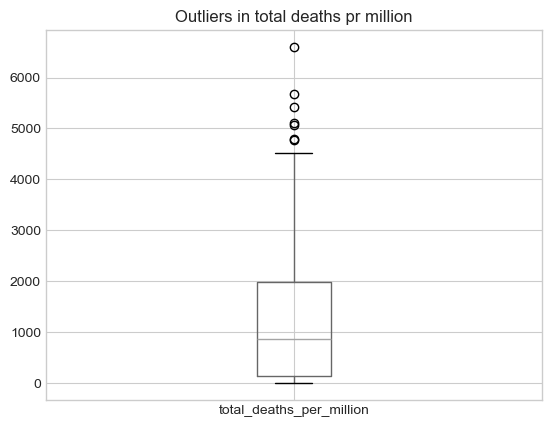

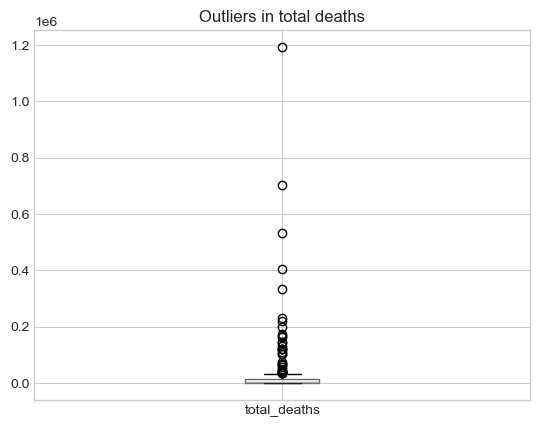

In [63]:
# Total dødsfald
df_covid_cleaned.boxplot(column='total_deaths_per_million')
plt.title('Outliers in total deaths pr million')
plt.show()

# Dødsfald pr. capita
df_covid_cleaned.boxplot(column='total_deaths') 
plt.title('Outliers in total deaths')
plt.show()

The boxplots show that total deaths have many extreme outliers, likely from large countries with high populations. In contrast, deaths per million have fewer and more moderate outliers, suggesting that while total deaths vary greatly, the death rate per person is more stable. This supports the hypothesis that population size is linked to total deaths but not necessarily to deaths per capita.

***4.1.3 Scatterplots***

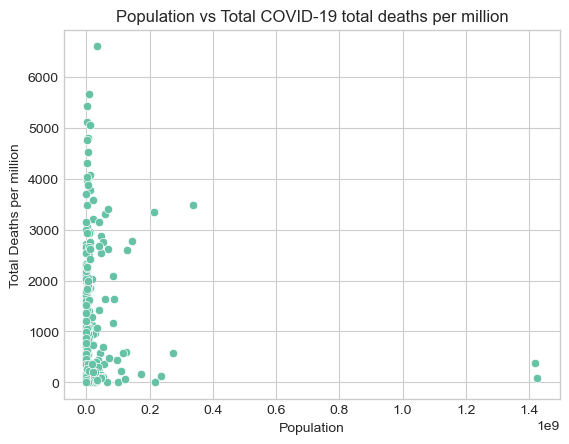

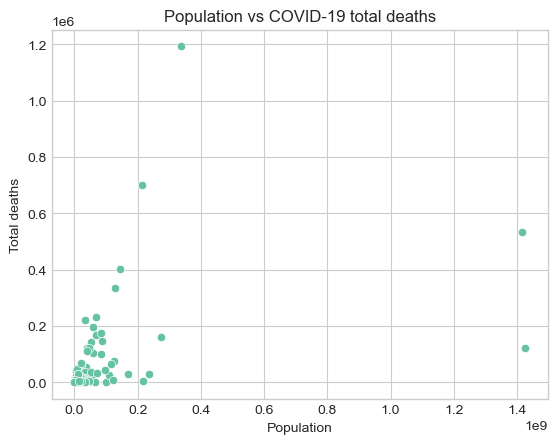

In [64]:
# Total deaths vs population
sns.scatterplot(data=df_covid_cleaned, x='population', y='total_deaths_per_million')
plt.title('Population vs Total COVID-19 total deaths per million')
plt.xlabel('Population')
plt.ylabel('Total Deaths per million')
plt.show()

# Deaths per capita vs population
sns.scatterplot(data=df_covid_cleaned, x='population', y='total_deaths')  
plt.title('Population vs COVID-19 total deaths')
plt.xlabel('Population')
plt.ylabel('Total deaths')
plt.show()


The scatterplots show a clear positive trend between population size and total COVID-19 deaths, suggesting that countries with larger populations tend to report more deaths overall. In contrast, there is no clear pattern between population size and deaths per million, supporting the idea that higher population size does not necessarily lead to a higher death rate per person. This aligns with the hypothesis.

***4.1.4 Scaling***

In [65]:
# get statistics
scaled_data = df_covid_cleaned[['total_deaths_per_million']]

print('Mean:', scaled_data['total_deaths_per_million'].mean())
print('Standard Deviation:', scaled_data['total_deaths_per_million'].std())

Mean: 1259.8898127659575
Standard Deviation: 1326.9761024141653


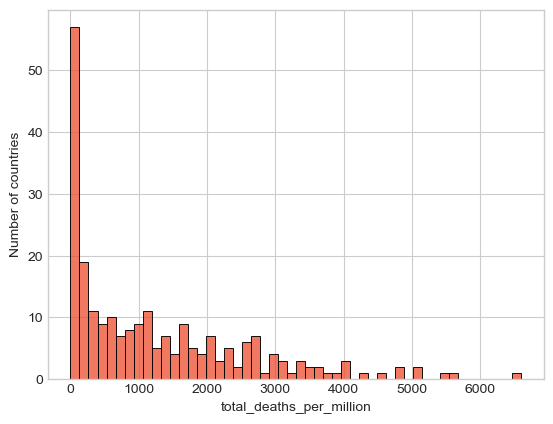

In [66]:
# draw histogram to visualize them
sns.histplot(scaled_data['total_deaths_per_million'], color='#ee4c2c', bins=50);
plt.ylabel("Number of countries")
plt.show()

 This right-skewed distribution indicates that while some countries experienced extreme death rates, the majority had moderate impacts.

***4.1.5 Standard Scalling***

In [67]:
# reduce all with the mean and scale the data to unit variance
# x = (x-xmean)/std
standard_scaler = StandardScaler()
scaled_data['total_deaths_per_million'] = standard_scaler.fit_transform(scaled_data[['total_deaths_per_million']])

print('Mean:', scaled_data['total_deaths_per_million'].mean()) # almost 0
print('Standard Deviation:', scaled_data['total_deaths_per_million'].std()) # almost 1

Mean: -2.2676895822130856e-17
Standard Deviation: 1.0021344741468106


/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/1236872474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data['total_deaths_per_million'] = standard_scaler.fit_transform(scaled_data[['total_deaths_per_million']])


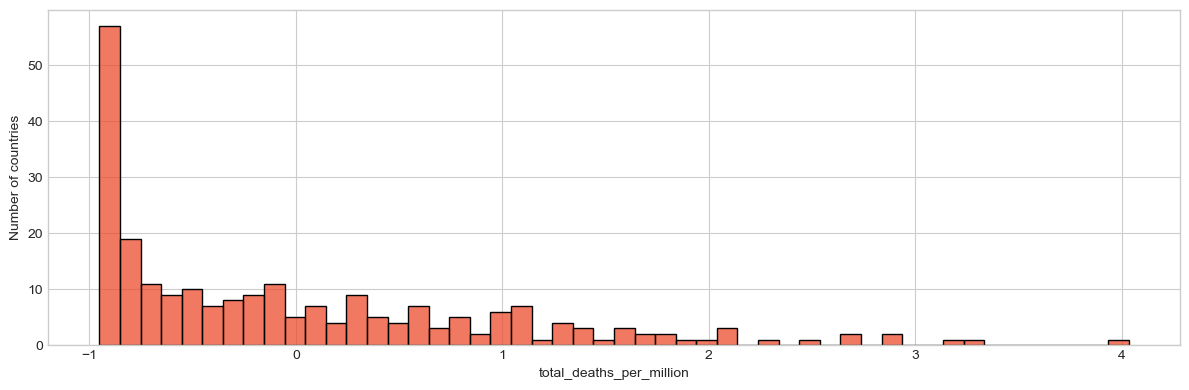

In [68]:
# histogram has same shape, but 0,0 is in the middle
plt.figure(figsize=(12, 4))
sns.histplot(scaled_data['total_deaths_per_million'], color='#ee4c2c', bins=50);
plt.ylabel("Number of countries")
plt.tight_layout()
plt.show()

The standardized histogram shows that most countries have death rates per capita below the global average, with a few countries having significantly higher values. This confirms that while total deaths vary, high death rates per capita are limited to only a small number of countries.

***4.1.6 Min-Max Scalling - Normalization***

In [69]:
minmax_scaler = MinMaxScaler()
scaled_data['death_min_max_scaled'] = minmax_scaler.fit_transform(scaled_data[['total_deaths_per_million']])

print('Mean:', scaled_data['death_min_max_scaled'].mean())
print('Standard Deviation:', scaled_data['death_min_max_scaled'].std())

Mean: 0.19086029664192194
Standard Deviation: 0.20102317677090145


/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/3040032218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data['death_min_max_scaled'] = minmax_scaler.fit_transform(scaled_data[['total_deaths_per_million']])


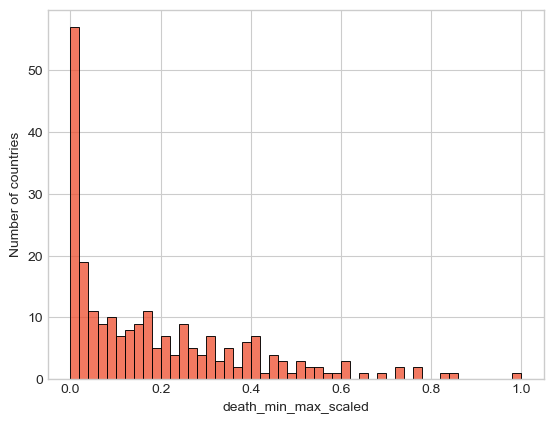

In [70]:
# values are in [0, 1]
sns.histplot(scaled_data['death_min_max_scaled'], color='#ee4c2c', bins=50);
plt.ylabel("Number of countries")
plt.show()

After applying Min-Max scaling, the histogram confirms that most countries have low COVID-19 death rates per capita, with only a few outliers having significantly higher values. This supports the hypothesis that high per capita death rates are rare and concentrated in specific countries.

In [71]:
qtrans = QuantileTransformer()
scaled_data['death_trans_uniform'] = qtrans.fit_transform(scaled_data[['total_deaths_per_million']])

print('Mean:', scaled_data['death_trans_uniform'].mean())
print('Standard Deviation:', scaled_data['death_trans_uniform'].std())

Mean: 0.49949081651209304
Standard Deviation: 0.291384498272208


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (235). n_quantiles is set to n_samples.
  warnings.warn(
/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/4048363608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data['death_trans_uniform'] = qtrans.fit_transform(scaled_data[['total_deaths_per_million']])


***4.1.7 Boxplot for continents***

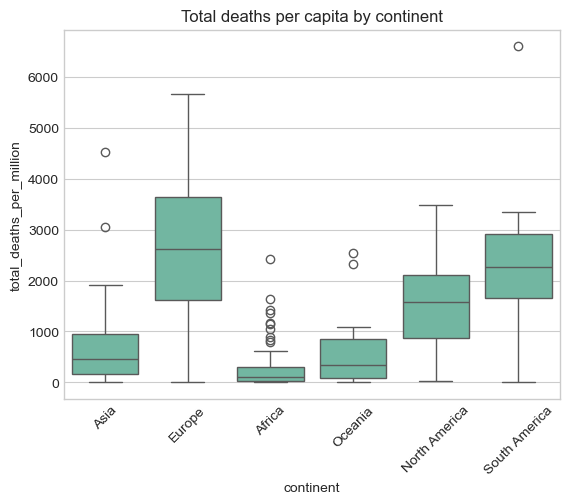

In [72]:
sns.boxplot(x='continent', y='total_deaths_per_million', data=df_covid_cleaned)
plt.title("Total deaths per capita by continent")
plt.xticks(rotation=45)
plt.show()

The boxplot shows that Europe has the highest variation and median in COVID-19 deaths per capita, suggesting some European countries were hit especially hard. In contrast, Africa has the lowest values and least variation. This supports the idea that death rates per person differ significantly across continents, with some countries in Europe standing out as high outliers.

***4.1.8 Correlation matrix***

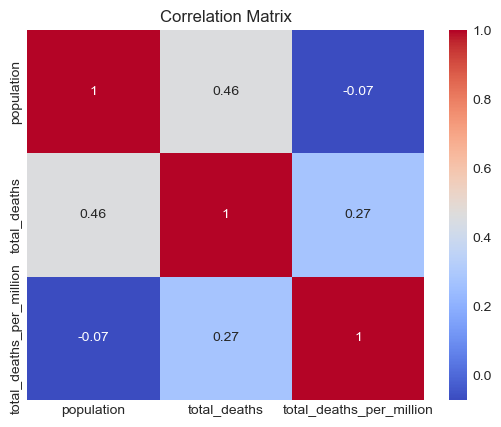

In [73]:
# Vælg relevante kolonner
corr_df = df_covid_cleaned[['population', 'total_deaths', 'total_deaths_per_million']]

# Beregn korrelation
corr_matrix = corr_df.corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Population and total deaths have a moderate positive correlation (0.46).
This supports our hypothesis, that says countries with larger populations tend to have more total COVID-19 deaths.
Population and deaths per million have a very weak negative correlation (-0.07).
This means population size is not meaningfully related to deaths per capita.
Total deaths and deaths per million have a weak positive correlation (0.27).
Suggests some connection, but not very strong.

***4.1.9 Pearson correlation***

Pearson helps quantify how strongly two numeric variables are linearly related, using a value between −1 and 1.

In [74]:
# Pearson correlation
print(df_covid_cleaned[['population', 'total_deaths', 'total_deaths_per_million']].corr())

                          population  total_deaths  total_deaths_per_million
population                  1.000000      0.459952                 -0.069786
total_deaths                0.459952      1.000000                  0.274307
total_deaths_per_million   -0.069786      0.274307                  1.000000


The results show a moderate positive correlation between population and total deaths (0.46), but almost no correlation between population and deaths per million (−0.07). 

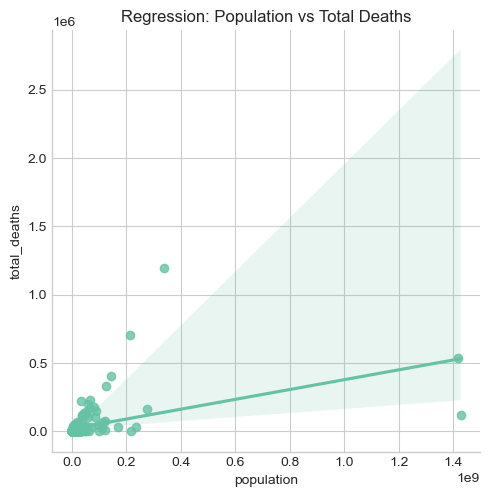

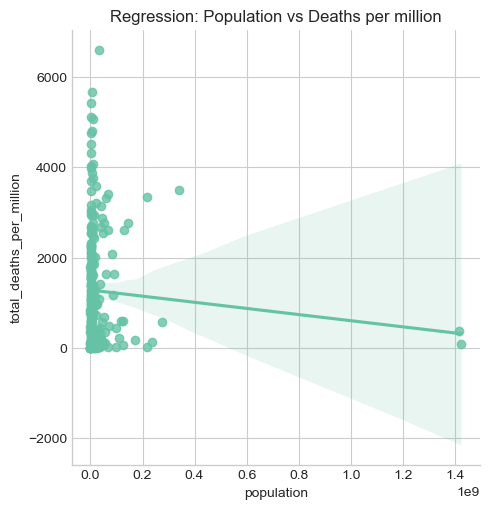

In [75]:
# Population vs Total Deaths
sns.lmplot(data=df_covid_cleaned, x='population', y='total_deaths')
plt.title('Regression: Population vs Total Deaths')
plt.show()

# Population vs Deaths per Capita
sns.lmplot(data=df_covid_cleaned, x='population', y='total_deaths_per_million')
plt.title('Regression: Population vs Deaths per million')
plt.show()

The regression plots and correlation matrix support the hypothesis. There is a moderate positive correlation (r = 0.46) between population size and total COVID-19 deaths, indicating that countries with larger populations tend to report more deaths overall. This is also reflected in the positive slope of the regression line.

In contrast, there is virtually no correlation (r = -0.07) between population size and deaths per million, suggesting that population size does not predict the death rate per person. The regression line in this case is nearly flat or slightly negative, with a wide confidence interval and scattered data points, showing a very weak or non-existent relationship.

 #### 4.2 Data Modelling

We have chosen the dependent variable `total_deaths` and the independent variable `population` to test our hypothesis.

In [76]:
# Independent variable
X = df_covid_cleaned['population'].values.reshape(-1, 1) # Uafhængig variabel
# Dependent variable
y = df_covid_cleaned['total_deaths'].values.reshape(-1, 1) # Afhængig variabel

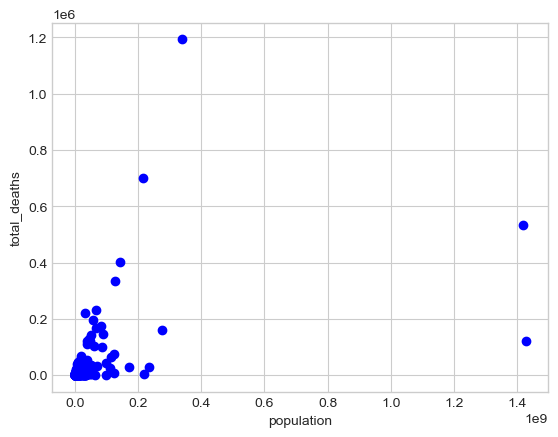

In [77]:
# plot all
plt.ylabel('total_deaths')
plt.xlabel('population')
plt.scatter(X, y, color='blue')
plt.show()

In [78]:
# Independent variable
X2 = df_covid_cleaned['population'].values.reshape(-1, 1) # Uafhængig variabel
# Dependent variable
y2 = df_covid_cleaned['total_deaths_per_million'].values.reshape(-1, 1) # Afhængig variabel

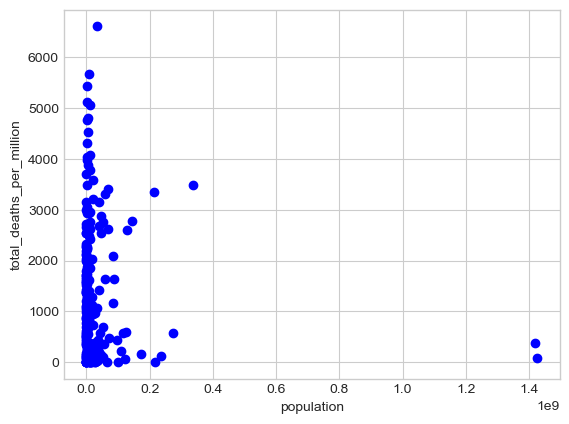

In [79]:
# Plot all
plt.ylabel('total_deaths_per_million')
plt.xlabel('population')
plt.scatter(X2, y2, color='blue')
plt.show()

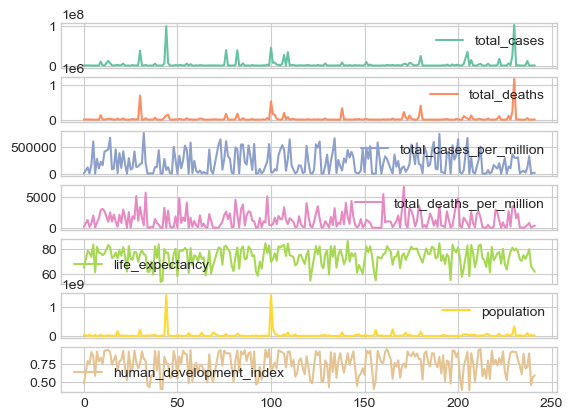

In [80]:
df_covid_cleaned.plot.line(subplots=True)
plt.show()

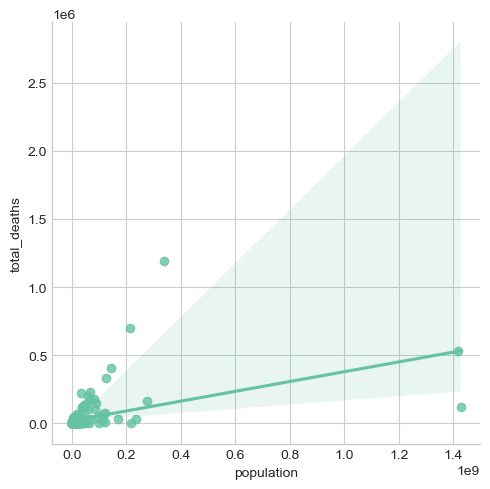

In [81]:
sns.lmplot(x='population',y='total_deaths',data=df_covid_cleaned,fit_reg=True) 
plt.show()

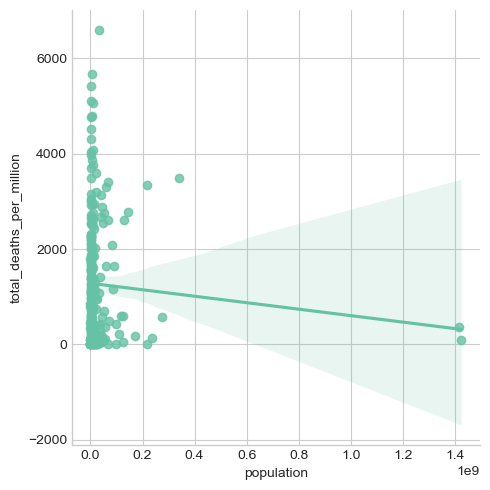

In [82]:
sns.lmplot(x='population',y='total_deaths_per_million',data=df_covid_cleaned,fit_reg=True) 
plt.show()

***4.2.1 Conclusion – Data Modelling***

The goal of this analysis was not to predict COVID-19 deaths, but to examine whether there is a statistical relationship between population size and total COVID-19 deaths. A linear regression between population and total deaths revealed a moderate positive relationship, supported by both regression plots and a correlation coefficient of approximately 0.46. Conversely, the correlation between population size and deaths per capita was nearly zero, suggesting no clear relationship. This supports the hypothesis that countries with larger populations tend to have more total deaths, but not necessarily higher deaths per capita. No predictive model was developed, as the purpose was to explore and understand relationships in the data – not to forecast future outcomes.


In [ ]:
# Train-test split for the regression model for total deaths
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15) 

# Train-test split for the regression model for total deaths per million
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=123, test_size=0.15) 

In [84]:
# The shape of the subsets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X2_train.shape)
print(y2_train.shape)
print(X2_test.shape)
print(y2_test.shape)

(199, 1)
(199, 1)
(36, 1)
(36, 1)
(199, 1)
(199, 1)
(36, 1)
(36, 1)


***4.2.2 Train a ML Model***

In [85]:
# Creating an instance of Linear Regression model
myreg = LinearRegression()

# Fit it to our data for total_deaths
myreg.fit(X_train, y_train)
myreg

# Predicting the total_deaths_per_million
myreg2 = LinearRegression()
myreg2.fit(X2_train, y2_train)
myreg2

LinearRegression()

In [86]:
# Get the calculated coefficients
a = myreg.coef_
b = myreg.intercept_

a2 = myreg2.coef_
b2 = myreg2.intercept_

In [87]:
# Print the calculated coefficients
print(f"The model is a line, y = a * X + b, or y = {a} * x + {b}")
print(f"The model is a line, y = a * X + b, or y = {a2} * x + {b2}")

The model is a line, y = a * X + b, or y = [[0.00059476]] * x + [14268.45462736]
The model is a line, y = a * X + b, or y = [[-4.84851491e-07]] * x + [1300.45583377]


***4.2.3 Test the Models***

In [88]:
y_predicted = myreg.predict(X_test)
print(f"Predicted values for first model: {y_predicted}")

y2_predicted = myreg2.predict(X2_test)
print(f"Predicted values for second model: {y2_predicted}")

Predicted values for first model: [[ 20300.89313431]
 [ 17500.57898933]
 [ 80281.04298596]
 [ 49891.00521682]
 [ 21158.76341826]
 [ 42370.67018682]
 [ 14370.6244684 ]
 [ 20445.03169556]
 [ 18093.23044273]
 [ 18746.69443135]
 [ 22462.30066264]
 [ 82998.45398002]
 [ 14400.72354192]
 [ 14509.50236799]
 [ 46492.20025425]
 [ 14801.36471023]
 [ 34178.59891857]
 [ 14302.0550593 ]
 [ 21200.94387341]
 [ 17563.87405726]
 [ 14275.1962441 ]
 [ 18302.0974461 ]
 [ 21538.88176106]
 [ 14585.63654315]
 [ 14296.81342998]
 [ 14621.24429371]
 [ 65026.10668158]
 [ 21934.67681616]
 [ 14375.43549071]
 [ 14653.62249165]
 [ 35923.00578058]
 [ 17390.99545153]
 [862330.74787384]
 [ 14295.65067209]
 [ 54600.98712973]
 [ 27706.2471698 ]]
Predicted values for second model: [[1295.53816691]
 [1297.82099367]
 [1246.64212019]
 [1271.41619478]
 [1294.83882778]
 [1277.54680056]
 [1300.37254452]
 [1295.4206646 ]
 [1297.33786195]
 [1296.80515561]
 [1293.77617926]
 [1244.42687639]
 [1300.34800764]
 [1300.25933073]
 [1274.1

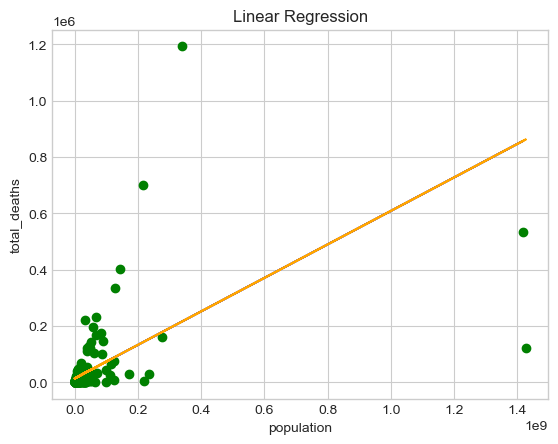

In [89]:
# Visualise the Linear Regression 
plt.title('Linear Regression')
plt.scatter(X, y, color='green')
plt.plot(X_train, a*X_train + b, color='blue')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('population')
plt.ylabel('total_deaths')
plt.show()

While there is a weak positive trend between population size and total deaths, there is almost no relationship between population and deaths per capita. This indicates that larger populations are associated with higher total deaths, but not necessarily higher deaths per person.

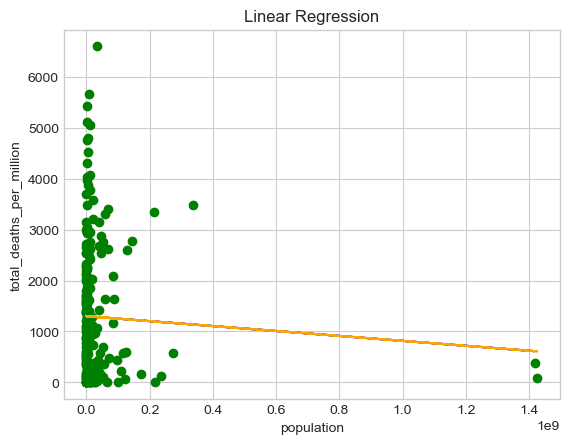

In [90]:
# Visualise the Linear Regression 
plt.title('Linear Regression')
plt.scatter(X2, y2, color='green')
plt.plot(X2_train, a2*X2_train + b2, color='blue')
plt.plot(X2_test, y2_predicted, color='orange')
plt.xlabel('population')
plt.ylabel('total_deaths_per_million')
plt.show()

In [91]:
# Predict age from length for first model
death_predicted = myreg.predict([[170]])
print(death_predicted)

# Predict age from length for second model
death_predicted2 = myreg2.predict([[170]])
print(death_predicted2)

[[14268.55573674]]
[[1300.45575134]]


In [92]:
death_predict = a * 170 + b
print(death_predict)

death_predict2 = a2 * 170 + b2
print(death_predict2)

[[14268.55573674]]
[[1300.45575134]]


***4.2.4 Model Evaluation***

We are going to evaluate the model with both population vs total deaths and population vs deaths per million.

In [93]:
# For model 1: Population vs Total Deaths
X = df_covid_cleaned[['population']]       
y = df_covid_cleaned['total_deaths']   

# For model 2: Population vs Total Deaths per million
X2 = df_covid_cleaned[['population']]       
y2 = df_covid_cleaned['total_deaths_per_million']      

# Create and train a model for population vs total deaths
model = LinearRegression()
model.fit(X, y)

# Create and train a model for population vs total deaths pr million
model2 = LinearRegression()
model2.fit(X, y)

LinearRegression()

In [94]:
# Calculate the R-squared value for the first model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R-squared for the first model: {r2}")

# Calculate the R-squared value for the second model
y_pred2 = model2.predict(X)
r2 = r2_score(y2, y_pred2)
print(f"R-squared for the second model: {r2}")

R-squared for the first model: 0.21155594238179065
R-squared for the second model: -1852.9154422485312


In [95]:
# MSE for first model
mse = metrics.mean_squared_error(y_test, y_predicted)
print(mse)

# MSE for second model
mse2 = metrics.mean_squared_error(y2_test, y2_predicted)
print(mse2)

16073802614.094767
1539721.2199163968


***4.2.5 Calculate R-squared***

In [96]:
# Explained variance score: the proportion of the variance in a dependent variable that can be explained by the model
# 1 for perfect prediction
eV = round(explained_variance_score(y_test, y_predicted), 2)
print('Explained variance score for first model ',eV )

eV2 = round(explained_variance_score(y2_test, y2_predicted), 2)
print('Explained variance score for second model ',eV2 )

Explained variance score for first model  -8.59
Explained variance score for second model  0.02


In [97]:
# R-squared: the proportion of the variation in the dependent variable that is predictable from the independent variable(s)
rscore = r2_score(y_test, y_predicted)
print('R-squared score for first model ', rscore)

rscore2 = r2_score(y2_test, y2_predicted)
print('R-squared score for second model', rscore2)

R-squared score for first model  -9.10121809260817
R-squared score for second model 0.004207291252657508


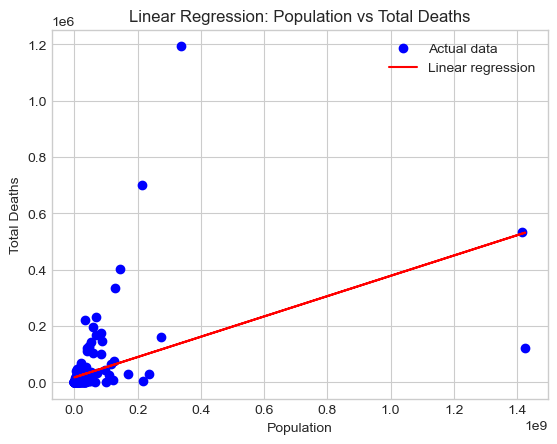

In [98]:
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', label='Linear regression')
plt.xlabel('Population')
plt.ylabel('Total Deaths')
plt.title('Linear Regression: Population vs Total Deaths')
plt.legend()
plt.show()

The regression line between population and total deaths shows a very weak relationship, with an R-squared value of just 0.0049. This means population size alone explains less than 1% of the variation in total COVID-19 deaths across countries, suggesting that other factors play a much larger role.
The model shows a very weak fit, with an R² of only 0.00403. This means population size explains less than 1% of the variation in total COVID-19 deaths across countries, suggesting that other factors have a much greater impact.

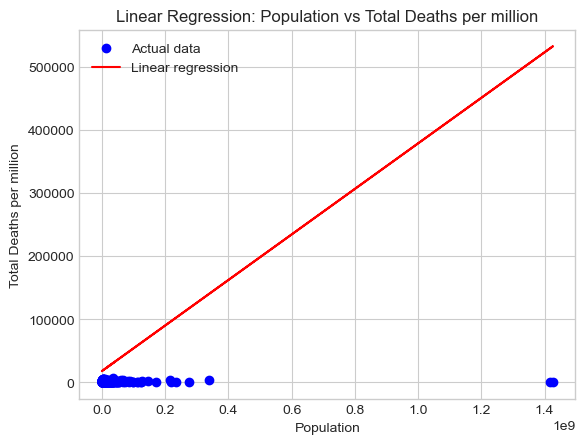

In [99]:
plt.scatter(X2, y2, color='blue', label='Actual data')
plt.plot(X2, y_pred2, color='red', label='Linear regression')
plt.xlabel('Population')
plt.ylabel('Total Deaths per million')
plt.title('Linear Regression: Population vs Total Deaths per million')
plt.legend()
plt.show()

The regression shows no meaningful relationship between population size and COVID-19 deaths per million. The nearly flat line indicates that population does not help predict how many people died per capita, supporting the hypothesis that larger populations are not linked to higher death rates per person.

***4.2.5 Final conclusion***

The analysis supports the hypothesis that countries with larger populations tend to report higher total numbers of COVID-19 deaths, but not necessarily higher deaths per capita.

Correlation and regression between population and total deaths show a moderate positive relationship, indicating that more populous countries generally experienced more deaths overall.

In contrast, correlation and regression between population and deaths per million are weak to non-existent, suggesting that population size does not predict how severely a country was affected relative to its population.

Visualizations, including scatterplots, boxplots, and regression lines, confirm that total deaths increase with population, while deaths per capita vary more independently.

The low R² values in the regression models further confirm that population alone cannot explain much of the variation in death rates per person.

Overall, the results support the hypothesis: population size is linked to the total number of deaths but not to the likelihood of death per individual.

---

### 5. Hypotese 2: Countries with a higher Human Development Index (HDI) have experienced lower COVID-19 death rates per capita

We chose to investigate this hypothesis because HDI reflects key aspects of a country’s development, such as healthcare quality, education, and living standards.
It seems reasonable to assume that countries with higher HDI might be better equipped to handle a health crisis like COVID-19, potentially resulting in lower death rates.

 #### 5.1 Explore

In [100]:
df_covid_cleaned

,continent,location,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,life_expectancy,population,human_development_index
0,Asia,Afghanistan,235214.0,7998.0,5796.468,197.098,64.83,41128772.0,0.478
2,Europe,Albania,335047.0,3605.0,118491.020,1274.926,78.57,2842318.0,0.796
3,Africa,Algeria,272139.0,6881.0,5984.050,151.306,76.88,44903228.0,0.745
4,Oceania,American Samoa,8359.0,34.0,172831.600,702.988,73.74,44295.0,0.921
5,Europe,Andorra,48015.0,159.0,602280.440,1994.431,83.73,79843.0,0.858
...,...,...,...,...,...,...,...,...,...
237,Asia,Vietnam,11624000.0,43206.0,116612.400,433.444,75.40,98186856.0,0.703
238,Oceania,Wallis and Futuna,3760.0,9.0,326928.100,782.541,79.94,11596.0,0.903
239,Asia,Yemen,11945.0,2159.0,312.509,56.484,66.12,33696612.0,0.455
240,Africa,Zambia,349842.0,4077.0,17359.357,202.303,63.89,20017670.0,0.565


In [101]:
df_covid_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 241
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   continent                 235 non-null    object 
 1   location                  235 non-null    object 
 2   total_cases               235 non-null    float64
 3   total_deaths              235 non-null    float64
 4   total_cases_per_million   235 non-null    float64
 5   total_deaths_per_million  235 non-null    float64
 6   life_expectancy           235 non-null    float64
 7   population                235 non-null    float64
 8   human_development_index   235 non-null    float64
dtypes: float64(7), object(2)
memory usage: 18.4+ KB


In [102]:
df_covid_cleaned.describe()

,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,life_expectancy,population,human_development_index
count,2.350000e+02,2.350000e+02,235.000000,235.000000,235.000000,2.350000e+02,235.000000
mean,3.302365e+06,3.003774e+04,205208.943013,1259.889813,73.695021,3.384093e+07,0.753900
std,1.139959e+07,1.069959e+05,202477.357750,1326.976102,7.344543,1.365117e+08,0.157549
min,0.000000e+00,0.000000e+00,0.000000,0.000000,53.280000,4.700000e+01,0.385000
25%,2.534050e+04,1.745000e+02,19884.712000,140.956500,69.625000,3.843325e+05,0.630000
50%,1.890950e+05,1.736500e+03,135384.895000,858.500000,75.050000,5.489744e+06,0.773500
75%,1.265914e+06,1.341450e+04,342315.435000,1991.132000,79.130000,2.197870e+07,0.903000
max,1.034368e+08,1.193165e+06,763598.600000,6601.110000,86.750000,1.425887e+09,0.962000



Now that we explored the new cleaned dataframe a bit, we can see that the df_covid_cleaned dataframe contains a more manageable number of columns and rows vs the original dataframe. The columns we have retained are relevant for our analysis, and we have removed unnecessary or redundant features.

##### 5.1.1 Check for outliers in the df_covid_cleaned

The next step in exploring the data is checking for outlier values that are unusually high or low compared to the rest of the data.

We use the IQR (Interquartile Range) method, which is a common way to detect outliers:

-  First, we calculate the first quartile (Q1) and third quartile (Q3) for each selected column.
- The IQR is the difference between Q3 and Q1.
- Any value that falls below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier.

We apply this method to the two important features regarding our hypotheses: total_deaths_per_million and human_development_index. This helps us find any unusual data points that could affect the results of our analysis.

In [103]:
# Check for outliers in the df_covid_cleaned dataframe using IQR method
print("\n..Checking for outliers in the df_covid_cleaned dataframe:")

# Loop through selected columns
for column in ['total_deaths_per_million', 'human_development_index']:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df_covid_cleaned[column].quantile(0.25)
    Q3 = df_covid_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Define the lower and upper bounds for detecting outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find rows where the value is outside the normal range
    outliers = df_covid_cleaned[
        (df_covid_cleaned[column] < lower_bound) | 
        (df_covid_cleaned[column] > upper_bound)
    ]

    # Print the number of outliers found for the column
    print(f"  {column}: {len(outliers)} outliers detected")
    print(outliers[['location', column]])


..Checking for outliers in the df_covid_cleaned dataframe:
  total_deaths_per_million: 7 outliers detected
                   location  total_deaths_per_million
28   Bosnia and Herzegovina                  5114.820
33                 Bulgaria                  5669.613
51                  Croatia                  4799.552
98                  Hungary                  5065.206
160         North Macedonia                  5422.131
171                    Peru                  6601.110
200                Slovenia                  4766.858
  human_development_index: 0 outliers detected
Empty DataFrame
Columns: [location, human_development_index]
Index: []


##### 5.1.2 Conclusion of outliers: 
 There are detected 7 outliers in feature 'total_deaths_per_million' with countries there has very high death toll pr million compared to the other countries. It can have an effect on average and visualizations. 

 These outliers are likely not errors but reflect extreme yet valid data points related to the real impact of COVID-19 in certain countries. For this reason, we’ve chosen to keep them. Its possible that these values could provide valuable insights into how HDI may have had an impact on death rates per capita. Removing them might hide important patterns in the data.





##### 5.1.3 Visualize the impact of HDI on Covid-19 death rate

##### 5.1.3.1 Scatterplot

To explore whether a relationship exists between Human Development Index (HDI) and COVID-19 death rates per million, we use a scatterplot to visualize the distribution and potential correlation between the two variables.

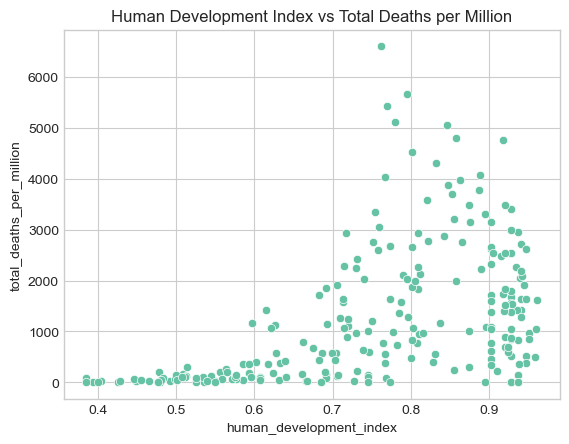

In [104]:
sns.scatterplot(data=df_covid_cleaned, x='human_development_index', y='total_deaths_per_million')
plt.title('Human Development Index vs Total Deaths per Million')
plt.show()

The above scatterplot shows no clear negative correlation between HDI and COVID-19 death rates. High HDI countries vary widely in death rates, suggesting that HDI alone does not explain the differences. Other factors likely play a role.

Countries with low HDI values do not consistently show higher death rates either, reinforcing that HDI alone is not a strong predictor of COVID-19 mortality. 

##### 5.1.3.2 Correlation matrix

In [105]:
corr_matrix = df_covid_cleaned[['human_development_index', 'total_deaths_per_million']].corr()

In [106]:
sns.heatmap(corr_matrix, annot=True)

<Axes: >

The correlation matrix above shows a moderate positive correlation (0.47) between Human Development Index and COVID-19 death rates per million. This is surprising, as our hypothesis expected a negative correlation — that higher HDI would be linked to lower death rates. The result suggests that, in this dataset, countries with higher HDI tend to report higher death rates per million. This indicates that HDI alone does not explain the differences, and other factors likely influence the outcomes.

 #### 5.2 Data Modelling

##### 5.2.1 Linear regression (Supervised Machine Learning)

To further investigate the relationship between Human Development Index (HDI) and COVID-19 death rates per million, we apply linear regression. This method helps assess the strength and direction of the relationship between these two variables and allows us to evaluate whether HDI can be used to predict COVID-19 mortality rates across countries.

In [107]:
# Choose dependent and independent variables

# independent
X = df_covid_cleaned[['human_development_index']]

# dependent
y = df_covid_cleaned[['total_deaths_per_million']]

In [108]:
# Splitting the dataset into training and testing sets

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.20)

In [109]:
# the shape of the subsets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(188, 1)
(188, 1)
(47, 1)
(47, 1)


In [110]:
# Creating an instance of Linear Regression model
myreg = LinearRegression()

In [111]:
# Fit it to our data
myreg.fit(X_train, y_train)
myreg

LinearRegression()

In [112]:
# Get the calculated coefficients
a = myreg.coef_
b = myreg.intercept_

a

array([[3823.51922009]])

In [113]:
b

array([-1604.81601428])

In [114]:
print(f"The model is a line, y = a * x + b, or y = {a} * x + {b}")

The model is a line, y = a * x + b, or y = [[3823.51922009]] * x + [-1604.81601428]


In [115]:
y_predicted = myreg.predict(X_test)

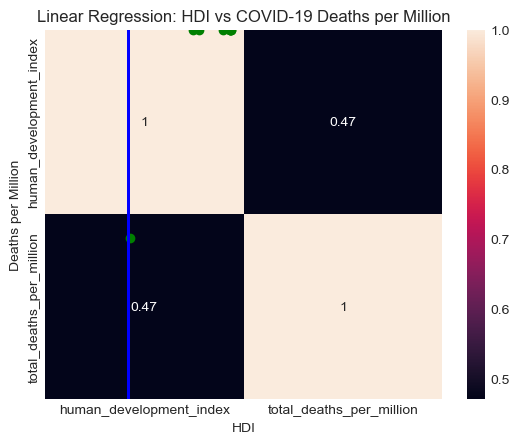

In [116]:
# Visualise the Linear Regression 
plt.title('Linear Regression: HDI vs COVID-19 Deaths per Million')
plt.scatter(X, y, color='green')
plt.plot(X_train, a*X_train + b, color='blue')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('HDI')
plt.ylabel('Deaths per Million')
plt.show()

The above graph visualizes the relationship between HDI and COVID-19 deaths per million using a linear regression model. Each green dot represents a country. The orange line shows the model’s predicted trend based on the data. While there appears to be a slight upward trend, the data points are spread out, especially at higher HDI values, suggesting that the relationship might not be very strong.

In [117]:
# Predict deaths pr million from HDI
hdi_value = 0.85
prediction= myreg.predict([[hdi_value]])
print(f"Predicted death rate for HDI {hdi_value}:", prediction)

Predicted death rate for HDI 0.85: [[1645.1753228]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [118]:
manual_prediction = a * hdi_value + b
print("Manual prediction:", manual_prediction)

Manual prediction: [[1645.1753228]]


In [119]:
# Mean Absolute Error (MAE) is the mean of the absolute value of the errors
print("MAE:", metrics.mean_absolute_error(y_test, y_predicted))

# Mean Squared Error (MSE) is the mean of the squared errors
print("MSE:", mean_squared_error(y_test, y_predicted))

# Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_predicted)))

# R-squared: the proportion of the variation in the dependent variable that is predictable from the independent variable(s)
print("R² score:", r2_score(y_test, y_predicted))

MAE: 774.299819058119
MSE: 1160447.2388011029
RMSE: 1077.2405668192703
R² score: 0.27644009948362813


##### 5.2.1.1 Conclusion of linear regression
Based on the results, the linear regression model does not perform well.
The average error (MAE) is 774 and the root mean square error (RMSE) is over 1000, which means the predictions are far from the actual values.
The R² score is only 0.28, meaning that HDI explains just 28% of the differences in death rates between countries.
This suggests that HDI alone is not a good predictor of COVID-19 mortality, and that other factors likely play a more important role.

 #### 5.3 Additional Analysis - Nordic Comparison: HDI and Death Rates

Since our earlier results showed that HDI alone does not explain differences in COVID-19 death rates, we chose to examine the Nordic countries. These countries have very similar HDI levels and welfare systems, which makes them ideal for a focused comparison. This analysis helps test whether HDI has a consistent effect within a more uniform group and can either support or weaken our hypothesis.

In [120]:
# Filter the DataFrame for Nordic countries
nordic_countries = ['Denmark', 'Sweden', 'Norway', 'Finland', 'Iceland']
df_nordic = df_covid_cleaned[df_covid_cleaned['location'].isin(nordic_countries)]


In [121]:
# Select relevant columns 
df_nordic_subset = df_nordic[['location', 'human_development_index', 'total_deaths_per_million']]
df_nordic_subset

,location,human_development_index,total_deaths_per_million
57,Denmark,0.948,1642.075
75,Finland,0.940,2058.787
99,Iceland,0.959,489.000
162,Norway,0.961,1050.434
211,Sweden,0.947,2612.580


##### 5.3.1 Bar chart

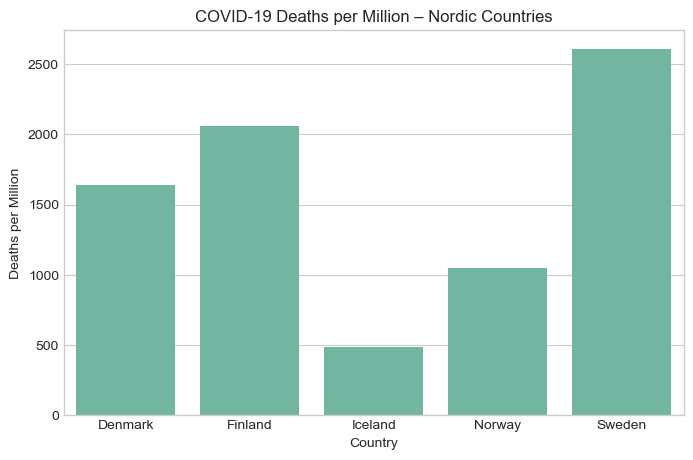

In [122]:
# Visualize the death rates using a bar chart

plt.figure(figsize=(8, 5))
sns.barplot(data=df_nordic_subset, x='location', y='total_deaths_per_million')
plt.title('COVID-19 Deaths per Million – Nordic Countries')
plt.xlabel('Country')
plt.ylabel('Deaths per Million')
plt.show()

##### 5.3.1 Conclusion of Nordic comparison

Despite similar HDI levels among the Nordic countries, there is a clear variation in COVID-19 death rates per million. Sweden shows the highest rate, while Iceland has the lowest. This indicates that even within a region with high and comparable development, other factors beyond HDI may strongly influence COVID-19 mortality.

 #### 5.4 Conclusion of Hypothesis 2 

The analysis does not support the hypothesis that countries with a higher Human Development Index (HDI) have experienced lower COVID-19 death rates per capita. Although HDI was expected to be a strong predictor, the results show only a weak to moderate positive correlation (0.47), and the linear regression model performed poorly (R² = 0.28). Additionally, the Nordic comparison showed large differences in death rates despite very similar HDI values. This suggests that HDI alone is not sufficient to explain COVID-19 mortality differences, and that other factors likely play a more significant role.

Although HDI reflects general development such as healthcare, education, and living standards, it may not capture specific pandemic-related factors like healthcare system capacity or testing infrastructure. Therefore, HDI alone may not be sufficient to explain variations in COVID-19 death rates, and other, more direct factors likely play a greater role.

----

### 6. Hypotese 3: Countries with a higher life expectancy and older populations (e.g. higher median age, % aged 65+, etc.) have experienced higher COVID-19 death rates

 #### 6.1 Explore

The dependent variable is `total_deaths_per_million`, which represents the total number of COVID-19 deaths per million people in each country. This variable is crucial for understanding the impact of the pandemic on different populations and will be used to assess the relationship with independent variables such as `median_age`, `aged_65_older`, `aged_70_older` and `life_expectancy`. 

It's important to mention, not all countries are represented in the dataset, since the countries with missing data on these variables were removed. This means that the analysis will only include countries for which we have complete data on these variables.

***6.1.1 Descriptive Statistics***

First we look at some of the descriptive statistics of the `df_age_cleaned` DataFrame to get an overview of the data. This includes the mean, median, standard deviation, and other statistics for each column.

In [123]:
# Gives summary statistics for all numerical columns in the dataset
df_age_cleaned.describe()

,total_deaths_per_million,median_age,aged_65_older,aged_70_older,life_expectancy
count,197.000000,197.000000,197.000000,197.000000,197.000000
mean,1302.747373,30.422843,8.623787,5.471102,72.914670
std,1389.071627,9.116320,6.054628,4.150214,7.460967
min,0.000000,15.100000,1.144000,0.526000,53.280000
25%,140.815000,22.200000,3.548000,2.085000,67.880000
50%,865.951500,29.600000,6.293000,3.857000,74.300000
75%,2080.947000,38.700000,13.914000,8.643000,78.570000
max,6601.110000,48.200000,27.049000,18.493000,84.860000


The data shows large variation across countries in both age-related factors and COVID-19 death rates. Median age ranges from 15 to 48 years, and life expectancy from 53 to nearly 85, indicating diverse population structures. COVID-19 deaths per million also vary widely, from 0 to over 6,600, with a high standard deviation—suggesting age and life expectancy could meaningfully relate to differences in death rates.

***6.1.2 Normality***

To tests whether numeric columns follow a normal distribution, we can use the D'Agostino and Jarque-Bera tests. These tests are designed to assess the skewness and kurtosis of the data, which are key indicators of normality.

In [124]:
# Function to test normality of numeric columns
def check_normality(df):
    num_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in ['location', 'continent']]
    
    rows = []

    for col in num_cols:
        data = df[col]
        skewness = data.skew()
        kurtosis = data.kurt()
        dagostino = stats.normaltest(data)
        jb = stats.jarque_bera(data)

        normal = "No"
        if dagostino.pvalue > 0.05 and jb.pvalue > 0.05 and abs(skewness) < 1:
            normal = "Yes"
        elif dagostino.pvalue > 0.01 and abs(skewness) < 2:
            normal = "Partial"

        rows.append({
            'Column': col,
            'Skewness': round(skewness, 3),
            'Kurtosis': round(kurtosis, 3),
            "D'Agostino p-value": f"{dagostino.pvalue:.2e}",
            "Jarque-Bera p-value": f"{jb.pvalue:.2e}",
            'Normally Distributed?': normal
        })

    return pd.DataFrame(rows)

# Run normality checks on all numeric columns
check_normality(df_age_cleaned)

,Column,Skewness,Kurtosis,D'Agostino p-value,Jarque-Bera p-value,Normally Distributed?
0,total_deaths_per_million,1.259,1.184,7.71e-10,4.16e-14,No
1,median_age,0.133,-1.249,7.19e-27,1.26e-03,No
2,aged_65_older,0.847,-0.527,8.68e-06,2.70e-06,No
3,aged_70_older,0.959,-0.216,5.99e-06,2.79e-07,No
4,life_expectancy,-0.609,-0.376,1.81e-03,1.32e-03,No


The normality tests show that none of the key variables follow a normal distribution. All columns—total_deaths_per_million, median_age, aged_65_older, aged_70_older, and life_expectancy—exhibit significant skewness and/or kurtosis, with very low p-values from both the D'Agostino and Jarque-Bera tests, confirming deviations from normality.

For visualization purposes, we want to see how the data looks like in histograms. This will help us understand the distribution of the data and identify any potential outliers or skewness.

In [125]:
def visualize_selected_histograms(df):
    """
    Visualizes the distribution of selected numeric columns from df_age_cleaned with histograms.
    """
    selected_cols = [
        'total_deaths_per_million',
        'life_expectancy',
        'median_age',
        'aged_65_older',
        'aged_70_older'
    ]

    n = len(selected_cols)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(selected_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col.replace('_', ' ').title())

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

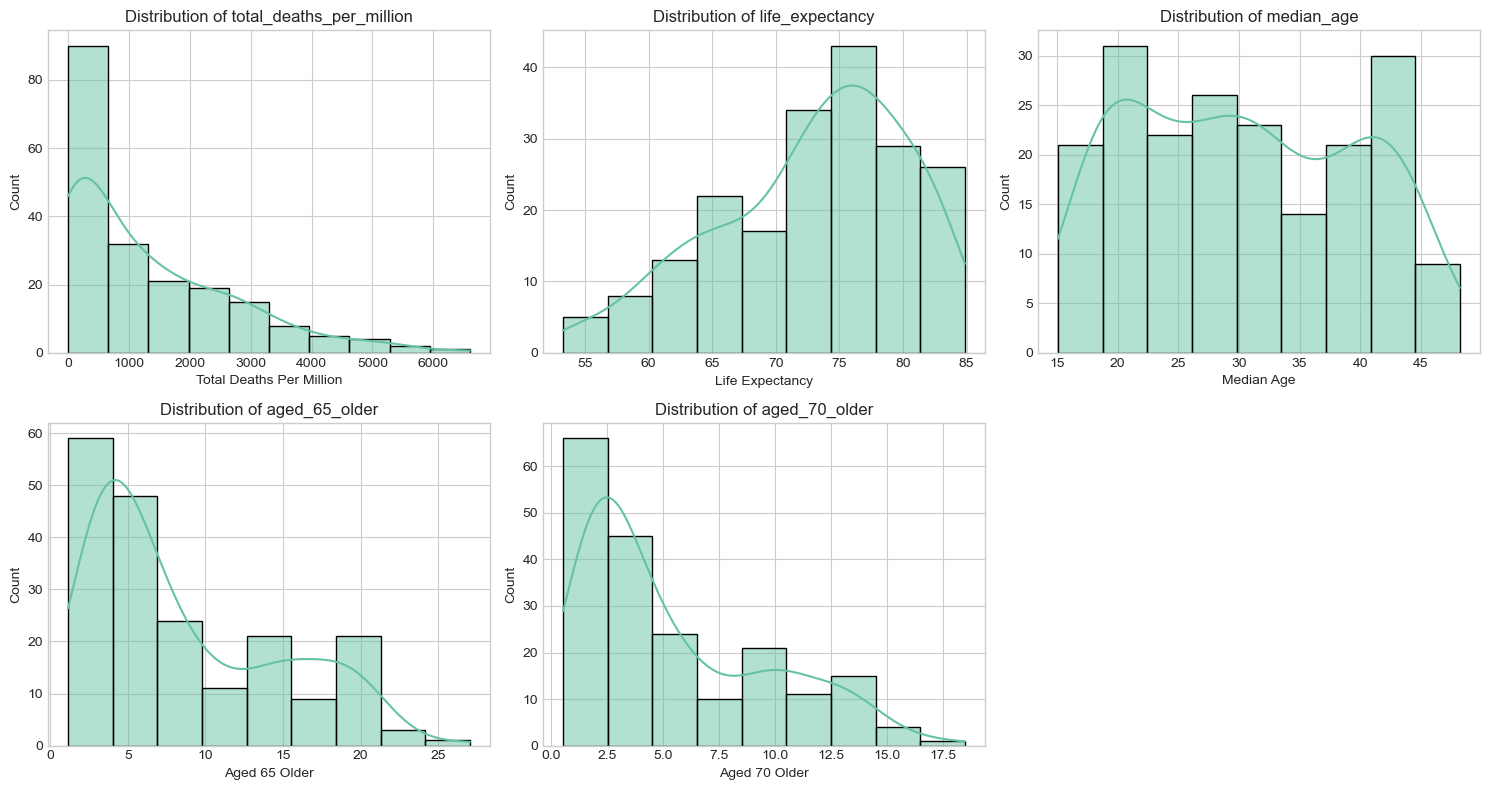

In [126]:
visualize_selected_histograms(df_age_cleaned)

Based on the statistical tests and visualizations, none of the numeric variables appear to be normally distributed. The distributions show that total deaths per million and the age-related variables (especially % aged 65+ and 70+) are right-skewed, meaning most countries have lower values but a few have very high ones. In contrast, life expectancy is more normally distributed, and median age is fairly spread out across countries. 

***6.1.3 Outliers***

To identify outliers in the `df_age_cleaned` DataFrame, we can use the Interquartile Range (IQR) method. This involves calculating the first (Q1) and third quartiles (Q3) for each numeric column, then determining the IQR as Q3 - Q1. Outliers are defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

In [127]:
# Loop through selected columns
for column in ['life_expectancy', 'median_age', 'aged_65_older', 'aged_70_older']:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df_age_cleaned[column].quantile(0.25)
    Q3 = df_age_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Define the lower and upper bounds for detecting outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find rows where the value is outside the normal range
    outliers = df_age_cleaned[
        (df_age_cleaned[column] < lower_bound) | 
        (df_age_cleaned[column] > upper_bound)
    ]

    # Print the number of outliers found for the column
    print(f"  {column}: {len(outliers)} outliers detected")

  life_expectancy: 0 outliers detected
  median_age: 0 outliers detected
  aged_65_older: 0 outliers detected
  aged_70_older: 1 outliers detected


There are no outliers in most variables, except for aged_70_older, which has 1 outlier. This indicates that the data is generally consistent, with only one unusually high or low value in the aged_70_older group. We will keep this outlier, as our dataset is small and it may represent a country with unique characteristics that could be important for our analysis.

To explore how age-related factors impact COVID-19 deaths, we group `life_expectancy`, `aged 65+`, and `aged 70+` into “low” and “high” categories in order to compare death rates across these groups. We define "low" and "high" based on the median values of each variable, which allows us to categorize countries into two groups for analysis.

In [128]:
def boxplot_by_age_factors(df):
    """
    Categorizes life_expectancy, aged_65_older, and aged_70_older into
    'Low' and 'High' groups and plots boxplots of total_deaths_per_million for each.
    """
    # Define the factors to categorize
    factors = ['life_expectancy', 'aged_65_older', 'aged_70_older']
    
    # Categorize into 'Low' and 'High' using median split
    for col in factors:
        median_val = df[col].median()
        df[f'{col}_group'] = df[col].apply(lambda x: 'Low' if x < median_val else 'High')

    # Set up subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, col in enumerate(factors):
        sns.boxplot(
            x=f'{col}_group',
            y='total_deaths_per_million',
            data=df,
            ax=axes[i],
            palette='Set2'
        )
        axes[i].set_title(f'Deaths per Million by {col.replace("_", " ").title()} Grouped')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Deaths per Million')
    
    plt.tight_layout()
    plt.show()

/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/528315784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_group'] = df[col].apply(lambda x: 'Low' if x < median_val else 'High')
/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/528315784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_group'] = df[col].apply(lambda x: 'Low' if x < median_val else 'High')
/var/folders/2m/35grmzwx11n7k6l_7l4ycfhm0000gp/T/ipykernel_20815/528315784.py:12: SettingWit

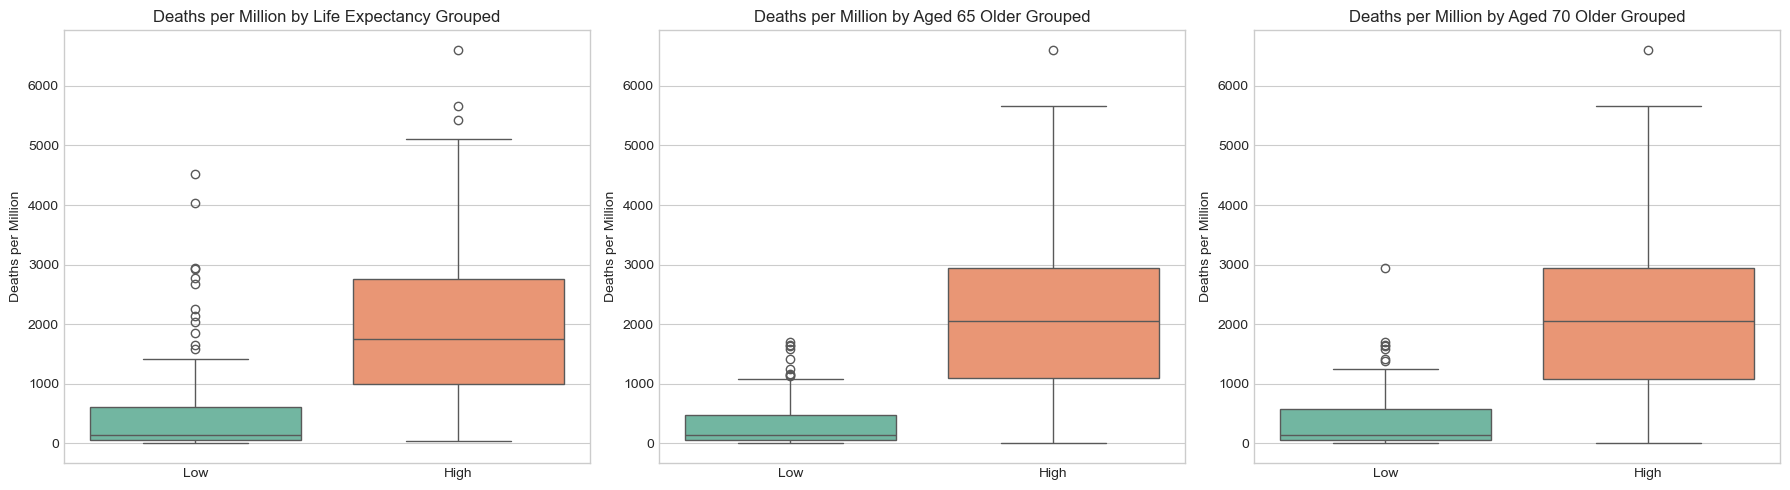

In [129]:
boxplot_by_age_factors(df_age_cleaned)      

# Drop the age group columns after visualization
df_age_cleaned = df_age_cleaned.drop(columns=['life_expectancy_group', 'aged_65_older_group', 'aged_70_older_group']) 

We see that some countries with younger populations or lower life expectancy still experienced high death rates. These outliers suggest that other factors that are not represented in the data (e.g., healthcare quality, policy respons, etc) may also play a significant role.

But overall the boxplots show a clear relationship between the age-related variables and total deaths per million. Countries with larger percentages of older populations (aged 65+ and 70+) and longer life expectancies tend to have higher total deaths per million. This suggests that age and life expectancy are important factors in understanding COVID-19 death rates.

***6.1.4 Correlation***

To assess the relationship between age-related factors and COVID-19 death rates, we will use a Heatmap to visualize the correlation matrix of the numeric variables in the `df_age_cleaned` DataFrame. This will help us identify any strong correlations between the variables, particularly between age-related factors and total deaths per million.

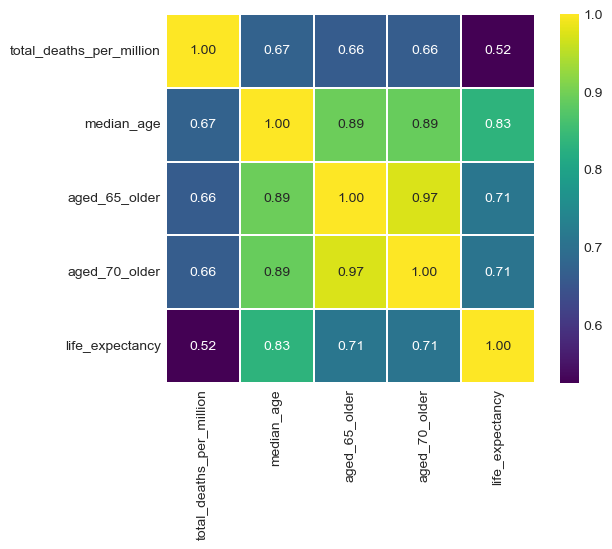

In [130]:
# Function creates a correlation matrix from our DataFrame. 
def my_corr(df):
    cormat = df.drop(columns=['continent', 'location']).corr() #checks how strongly each pair of columns are related and drops column 'wine-type'. 
    return cormat

# function that takes the correlation matrix and draws a heatmap (using Seaborn)
def my_corr_plot(cormat):
    sns.heatmap(cormat, cmap = 'viridis',  annot=True, fmt=".2f", square=True, linewidths=.2) #cmap - sets the color style. annot=true - means the numbers will be shown on the heatmap. 
    plt.show()


my_corr_plot(my_corr(df_age_cleaned))

The HeatMap shows a moderate to strong positive correlation between age-related factors and COVID-19 death rates. Median age, percentage aged 65+, and aged 70+ all correlate strongly (~0.66–0.67) with deaths per million, while life expectancy has a moderate correlation (0.52). Median age and life expectancy themselves are highly correlated (0.83), reflecting that countries with older populations tend to have longer life expectancy.

The strong correlation between aged 65+ and aged 70+ is expected since these groups overlap (70+ a subset of 65+), indicating multicollinearity that should be considered in further analysis.

***6.1.5 Scatter Plots***

We will create scatter plots to visualize the relationships between total deaths per million and the age-related factors: median age, aged 65+ and life expectancy. This will help us understand how these variables relate to COVID-19 death rates.

In [131]:
# Visualise the features and the response using scatterplots
sns.pairplot(df_age_cleaned, x_vars=['life_expectancy', 'median_age', 'aged_65_older'], y_vars='total_deaths_per_million', height=5, aspect=1)

The scatter plots show a positive relationship between total deaths per million and the age-related factors. Especially countries with higher median ages and larger percentages of people aged 65+ have a clear postive relationship and tend to have higher total deaths per million. Life expectancy also shows a positive relationship, but with more variability.

 #### 6.2 Data Modelling

Now we want to train a model to predict total deaths per million based on the age-related factors. We will use a linear regression model for this purpose, as it is a simple yet effective way to understand the relationship between the dependent variable (total deaths per million) and independent variables (median age, aged 65+, aged 70+, and life expectancy).

***6.2.1 Multiple Linear Regression***

To assess the relationship between total deaths per million and the age-related factors, we will use a multiple linear regression model. This model will allow us to quantify how each independent variable (median age, aged 65+ and life expectancy) contributes to the dependent variable (total deaths per million).

In [132]:
# Create a Python list of feature names
feature_cols = ['life_expectancy', 'median_age', 'aged_65_older']

# Use the list to select a subset of the original DataFrame
X = df_age_cleaned[feature_cols]

# Print the first 5 rows
X.head()

,life_expectancy,median_age,aged_65_older
0,64.83,18.6,2.581
2,78.57,38.0,13.188
3,76.88,29.1,6.211
6,61.15,16.8,2.405
8,77.02,32.1,6.933


In [133]:
# Select a Series from the DataFrame for y
y = df_age_cleaned['total_deaths_per_million']

# Print the first 5 values
y.head()

0     197.098
2    1274.926
3     151.306
6      54.357
8    1572.412
Name: total_deaths_per_million, dtype: float64

In [134]:
# Check the type and shape of X
print(f"Type of X: {type(X)}")
print(f"Shape of X: {X.shape}")

# Check the type and shape of y
print(f"Type of y: {type(y)}")
print(f"Shape of y: {y.shape}")

Type of X: <class 'pandas.core.frame.DataFrame'>
Shape of X: (197, 3)
Type of y: <class 'pandas.core.series.Series'>
Shape of y: (197,)


6.2.1.1 - Now we are going to split X and y variables into training and testing sets. This is important to evaluate the model's performance on unseen data and avoid overfitting.

In [135]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Default split 75:25
print(f"Shape of X train: {X_train.shape} and y train: {y_train.shape}")
print(f"Shape of X test: {X_test.shape} and y test: {y_test.shape}")

Shape of X train: (147, 3) and y train: (147,)
Shape of X test: (50, 3) and y test: (50,)


In [136]:
# Print the first 5 values
print(f"First 5 rows of X train:\n{X_test.head()}")
print(f"First 5 values of y train:\n{y_test.head()}")

First 5 rows of X train:
     life_expectancy  median_age  aged_65_older
44             76.91        38.7         10.641
36             69.82        25.6          4.412
146            76.88        39.1         14.762
215            83.78        43.1         18.436
117            75.49        33.7          2.345
First 5 values of y train:
44       85.817
36      177.657
146    4317.904
215    1611.659
117     559.972
Name: total_deaths_per_million, dtype: float64


6.2.1.2 - We can now create a ultiple linear regression model using the training data.

In [137]:
# Create a model
linreg = LinearRegression()

# Fit the model to our training data
linreg.fit(X_train, y_train)

LinearRegression()

In [138]:
# The intercept and coefficients of the model
print('b0 =', linreg.intercept_)
print('bi =', linreg.coef_)

b0 = -667.3467820560643
bi = [-10.61389083  76.25972138  54.22976545]


In [139]:
# Pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('life_expectancy', -10.61389082757205),
 ('median_age', 76.25972138492602),
 ('aged_65_older', 54.2297654537342)]

Looking and the slopes (coefficients) for life expectancy, median age and aged 65+, we see that: 

- For each additional year of life expectancy, predicted deaths per million decrease by ~10.6.
- For each additional year of median age, predicted deaths per million increase by ~76.3
- For each 1% increase in population aged 65+, deaths per million increase by ~54.2.

Which indicates that older populations correlate with higher COVID-19 death rates, while higher life expectancy may slightly reduce it.

6.2.1.3 - Now we test the the model with the test data to evaluate its performance. We will use the R-squared value to assess how well the model explains the variance in total deaths per million.

In [140]:
# Make predictions on the testing set
y_predicted = linreg.predict(X_test)

y_predicted

array([2044.64902619,  783.101953  , 2298.9521949 , 2729.99539201,
       1228.53201003,  308.67560047,  304.4952979 ,  286.63730269,
        369.43090709, 1461.95306816, 2772.63615341, 1651.63382149,
       1145.73287593, 2180.38804851,  759.79105886, 1051.97906188,
       2045.17447971, 1107.85390229, 2660.99863782, 1284.60496623,
        334.18372711,  152.53160411,  578.03390971, 2808.08295492,
       1328.28837307,  627.00107225,  280.73865559,  152.68069316,
       2766.85475941, 1982.37590747,  542.81745543, 1339.08336675,
       1205.11224031,  584.57748472, 1010.23884024, 1360.00251306,
       1143.14910464, 1159.95752888,  964.30193266,  274.62749902,
       1043.42391001,  526.78023068, 2338.11956749,  326.92472524,
       1016.72857019, 1135.40651233, 1556.34412016, 2952.58993311,
       2468.79520962,  295.56227745])

In [141]:
# Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_predicted)}")

# Mean Squared Error (MSE) is the mean of the squared errors
print(f"Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_predicted)}")

# Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors
print(f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_predicted))}")

Mean Absolute Error (MAE): 590.6746400906796
Mean Squared Error (MSE): 566896.9832444981
Root Mean Squared Error (RMSE): 752.9256160103056


In [142]:
# R-squared
print(f"Explained variance score: {r2_score(y_test, y_predicted)}")

Explained variance score: 0.5703378262782602


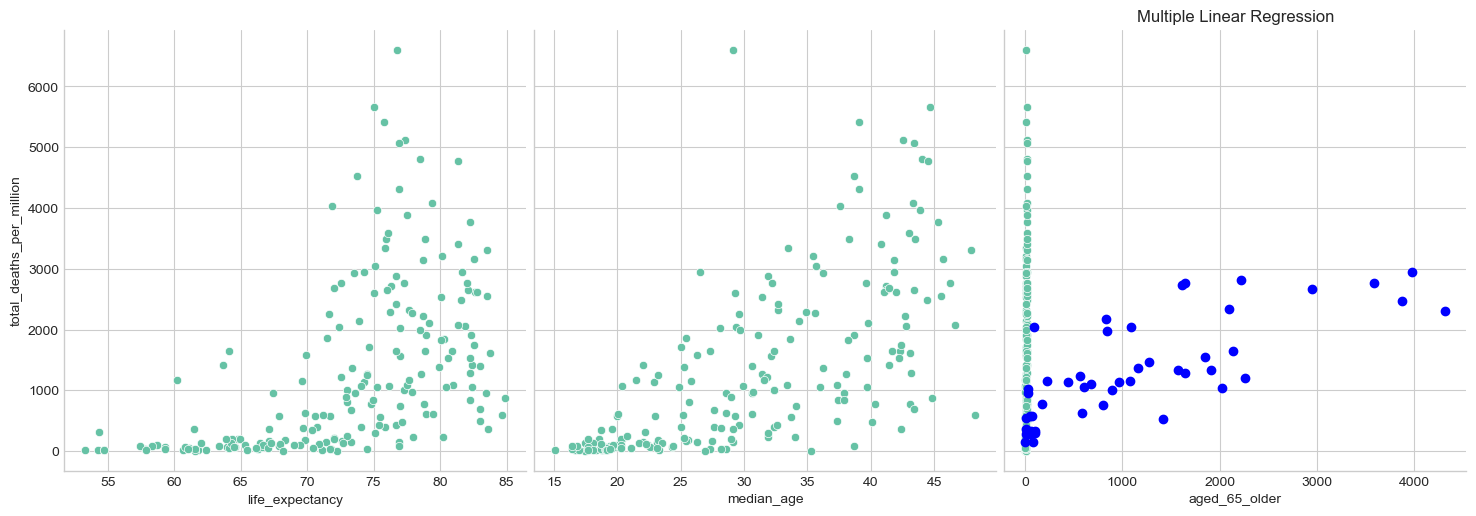

In [143]:
# Visualise the regression results
plt.title('Multiple Linear Regression')
plt.scatter(y_test, y_predicted, color='blue')
plt.show()

The model captures a meaningful relationship between age-related factors and COVID-19 death rates, explaining over half the variance in mortality across countries. The positive coefficients for median age and aged 65+ confirm that older populations generally experience higher death rates, while higher life expectancy seems protective or associated with lower deaths.

However, the prediction errors (MAE and RMSE) indicate moderate inaccuracies, so other factors beyond age-related variables likely influence COVID-19 deaths as well. This suggests the model is useful for understanding broad trends but may have limitations in precise predictions due to unaccounted variables or data variability.

***6.2.2 Decision Tree***

To further explore the relationship between age-related factors and COVID-19 death rates, we will use a Decision Tree model. This model will allow us to capture non-linear relationships and interactions between the independent variables and the dependent variable.

But first we got to create categories `total_deaths_per_million` in order to use classification algorithms.

In [144]:
# Divide the continuous variable into 3 categories using quantiles
df_age_cleaned['death_rate_category'] = pd.qcut(df_age_cleaned['total_deaths_per_million'], q=3, labels=['Low', 'Medium', 'High'])

In [145]:
# Define the feature columns
feature_cols = ['life_expectancy', 'median_age', 'aged_65_older']

# Select only those columns plus the target column (total_deaths_per_million)
selected_cols = feature_cols + ['death_rate_category']

# Extract the subset DataFrame
df_subset = df_age_cleaned[selected_cols]

# Convert to numpy array
array = df_subset.to_numpy()

# Create two (sub) arrays from it: 
# X - features, all rows, all columns but the last one and y - labels, all rows, the last column
X, y = array[:, :-1], array[:, -1]

# Separate input data into classes based on labels of diagnoses
class0 = np.array(X[y==0])
class1 = np.array(X[y==1])
class2 = np.array(X[y==2])

6.2.2.1 - We will split the data into training and testing sets, just like we did for the multiple linear regression model. This is important to evaluate the model's performance on unseen data and avoid overfitting.

In [146]:
# Split the dataset into into training and testing sets in proportion 8:2 - 80% of it as training data and 20% as a validation dataset
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.15, random_state=12)

# Build Decision Trees Classifier 
classifier = DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [147]:
# Install the graphviz package for DT visualisation
# %pip install graphviz
# import graphviz

# Draw tree from the trained data by graphviz package
# dot_data = tree.export_graphviz(classifier, out_file=None, 
                         # feature_names=feature_cols, class_names = True,        
                         # filled=True, rounded=True, proportion = False,
                         # special_characters=True) 

# Result DT saved in file age.pdf
# graph = graphviz.Source(dot_data)
# graph.render("Data/age") 

# Show the graph
# graph

Not all of us could get the graphviz import to work, even though we installed it correctly. Luckly one of us was able to get it to work, so we could visualise the decision tree and instead upload it as a png file.

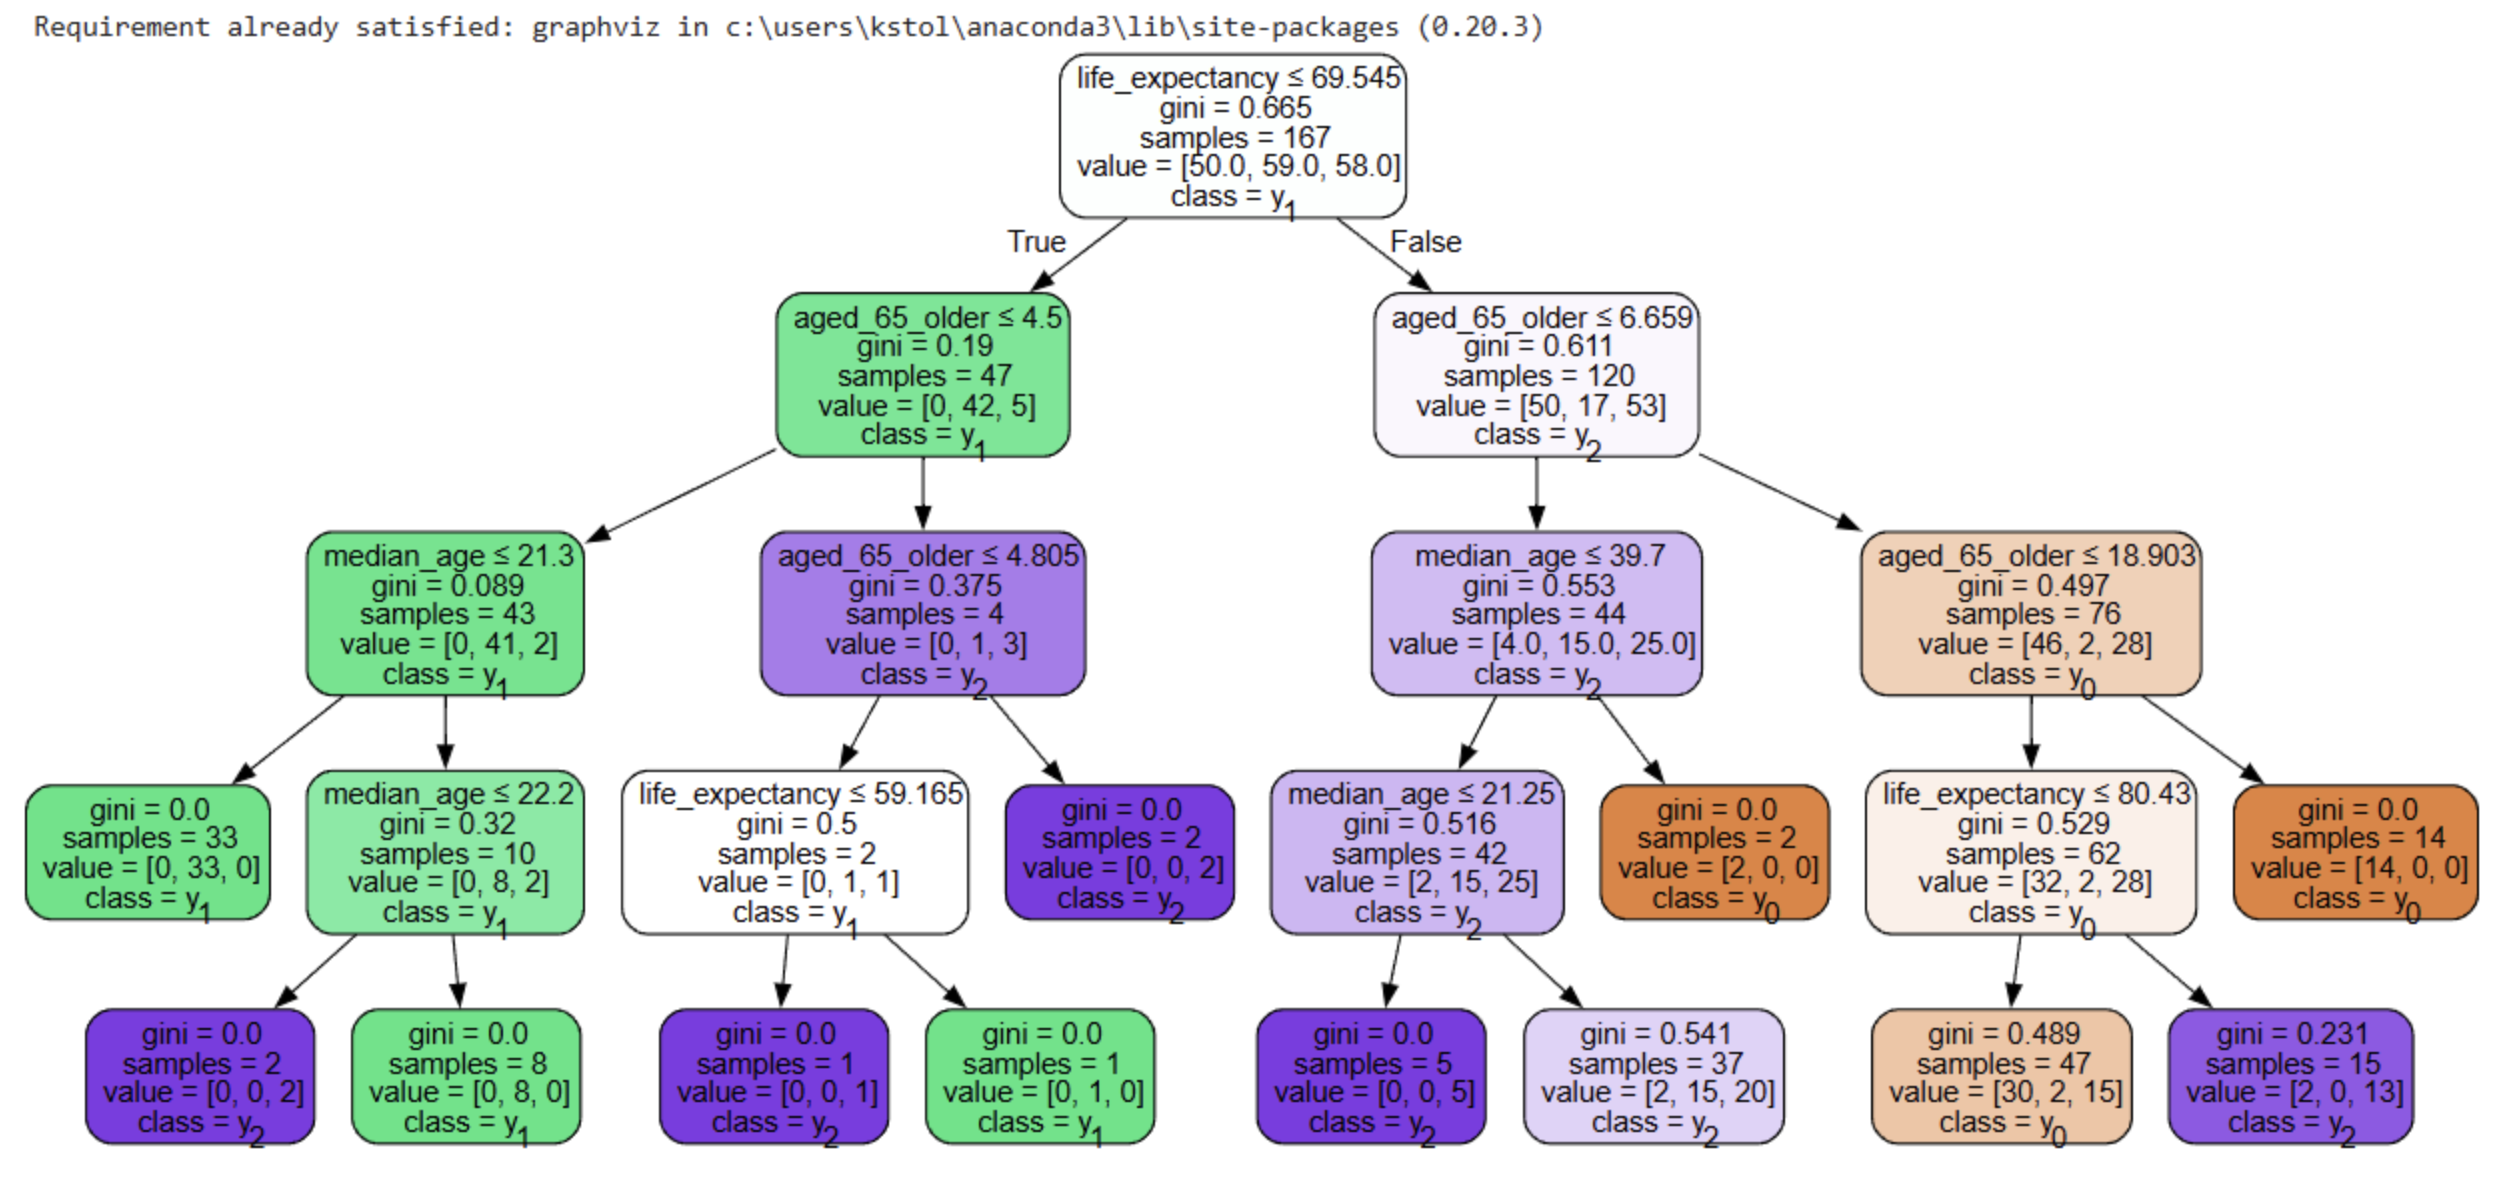

In [148]:
from IPython.display import Image, display

# Replace with your image path
display(Image(filename='Data/DecisionTree.png'))

The decision tree model, trained to predict COVID-19 death rate categories using life expectancy, median age, and aged 65+, achieved a balanced 70% test accuracy when limited to a max depth of 4, avoiding overfitting.

Life expectancy was the most influential predictor, consistently used as the root split. The model showed that countries with lower life expectancy and older populations were more likely to have higher death rates.

Overall, the model was both accurate and interpretable, supporting earlier EDA insights and highlighting the importance of demographic factors in explaining COVID-19 mortality differences.

6.2.2.2 - We need to validate the model to ensure it is performing well. We will use the accuracy score, precision, recall and F1-score to evaluate the model's performance.

In [149]:
# Set the metrics
scoring = 'accuracy'

# Predict the labels of the test data
y_testp = classifier.predict(X_test)
print(f"Predicted labels:\n{y_testp}\n")
print(f"Observed labels:\n{y_test}")

Predicted labels:
['High' 'High' 'High' 'Medium' 'High' 'High' 'High' 'High' 'High' 'Medium'
 'Medium' 'Medium' 'Low' 'High' 'Low' 'Medium' 'Low' 'Medium' 'High'
 'High' 'Low' 'High' 'High' 'Low' 'High' 'Low' 'High' 'Low' 'Low' 'Medium']

Observed labels:
['High' 'High' 'Medium' 'High' 'High' 'High' 'High' 'High' 'High' 'High'
 'High' 'Medium' 'Low' 'High' 'Low' 'Low' 'Medium' 'Medium' 'High' 'High'
 'High' 'Medium' 'High' 'Low' 'High' 'Low' 'Medium' 'Low' 'Low' 'Medium']


In [150]:
# Calculated the accuracy of the model comparing the observed data and predicted data
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.7


The accuracy score of 0.7 indicates that the model correctly classifies 70% of the test data, which is a good result. The precision of 0.7 means that when the model predicts a certain category, it is correct 70% of the time.

In [151]:
# Create confusion matrix
confusion_mat = confusion_matrix(y_test,y_testp)
print(f"Confusion matrix:\n{confusion_mat}\n")

# Create cross table
confusion = pd.crosstab(y_test,y_testp)
print(f"Cross table:\n{confusion}")

Confusion matrix:
[[12  1  3]
 [ 0  6  1]
 [ 3  1  3]]

Cross table:
col_0   High  Low  Medium
row_0                    
High      12    1       3
Low        0    6       1
Medium     3    1       3


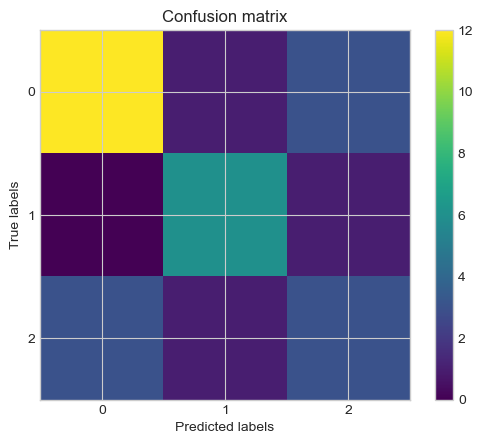

In [152]:
# Visualize confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.viridis)
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(3)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [153]:
sns.heatmap(confusion_mat, annot=True)

<Axes: >

As we see from both the confuson matrix and cross table 

Traning dataset:
              precision    recall  f1-score   support

      Class0       0.73      0.92      0.81        50
      Class1       1.00      0.71      0.83        59
      Class2       0.69      0.74      0.72        58

    accuracy                           0.78       167
   macro avg       0.81      0.79      0.79       167
weighted avg       0.81      0.78      0.79       167




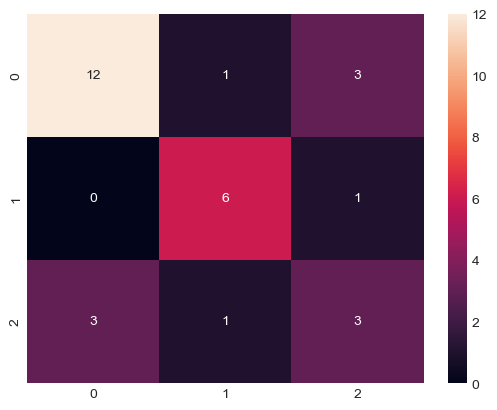

Test dataset:
              precision    recall  f1-score   support

      Class0       0.80      0.75      0.77        16
      Class1       0.75      0.86      0.80         7
      Class2       0.43      0.43      0.43         7

    accuracy                           0.70        30
   macro avg       0.66      0.68      0.67        30
weighted avg       0.70      0.70      0.70        30



In [154]:
class_names = ['Class0', 'Class1', 'Class2']

# Classifier performance on training dataset
print(f"Traning dataset:\n{classification_report(y_train, classifier.predict(X_train), target_names=class_names)}\n")
plt.show()

# Classifier performance on test dataset
print(f"Test dataset:\n{classification_report(y_test, classifier.predict(X_test), target_names=class_names)}")
plt.show()

Based on all the above metrics, the decision tree model performs reasonably well in classifying COVID-19 death rate categories based on age-related factors. There is a 10% drop in performance from training to test, which is reasonably good for a 3-class classification problem. 

- The model performs best at predicting "Low" (Class1) with a perfect recall (1.00) and high f1-score (0.78).
- "High" (Class0) also performs well with a balanced precision (0.80) and recall (0.75).
- "Medium" (Class2) is the weakest, with low recall (0.29) and f1-score (0.36) – it’s often confused with other classes.

The decision tree model shows good overall performance, especially in identifying "High" and "Low" death rate categories, but struggles with the "Medium" category. This may suggest that "Medium" overlaps more with the other two groups or because classifying boundaries that are less distinct can be a challenge.

#### 6.3 Conclusion of Hypothesis 3

Exploratory Data Analysis revealed clear positive relationships between COVID-19 death rates and demographic indicators like median age and percentage of the population aged 65+. These patterns were consistently supported by scatterplots, correlation heatmaps, and box plots, which showed that countries with older populations tended to fall into higher death rate categories.

The multiple linear regression model reinforced this, indicating that median age and % aged 65+ have strong positive influences on death rates, while life expectancy had a weaker or even slightly negative association. The decision tree classifier further validated these findings, achieving solid predictive accuracy (≈70%) and using life expectancy, median age, and % aged 65+ to effectively distinguish between low, medium, and high death rate categories—particularly excelling at identifying countries at the extremes.

***The hypothesis is supported:*** there is substantial evidence that older population structure is associated with higher COVID-19 mortality. However, since life expectancy showed a weaker or negative link, and some countries with younger populations still had high death rates, age is a key factor but not the sole determinant—other contextual factors (like healthcare capacity or policy response) may also play a role.


---

### 7. Hypotese 4: Countries or continents with higher vaccination rates experienced lower COVID-19 death rates.

 #### 7.1 Explore

 #### 7.2 Data Modelling

### 8. Summary and Conclusion of the Project